In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate
import time

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import diffrax
from jax.scipy import optimize

In [2]:
import jaxopt

In [3]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0)]

define

In [4]:

class SP_XY_Network:
    
    '''
    This is aimed to implement a neural network consisting of XY oscillators with bias term.
    We only define the network. The datat need to be got from outside.


    Terms: 
        data: original data
        phase: a configuration of every cells
    
    ===========================================
    
    Variables: 
    
        Parameters: 
        
            (set in __init__())
            N: number of neurons (including input and output cells)
            N_ev: maximum number of updating when looking for the equilibrium (free and with cost function)
            N_epoch: maximum number of iteration when doing gradient descent for the weights
            dt: time step for evolution to find equilibrium
            tol_eq: tolerance for searcheng for the equilibrium
            tol_W: tolerance for optimizing weights
            N_input: number of input cells
            N_output: number of output cells
            
            (set in get_training/test_data)
            N_sample: number of samples for training
            N_test: number of data sets fot validation test
            
            (set to be 0 in __init__ and updated when getting data)
            wieghts_0: initiate value for couplings
            phase_0: initiate configuration of all cells
            
        --------------------------
            
        External Data:
        
            (set in __init__())
            input_index: indices of input cells
            output_index: indices of output cells
            
            (set to be 0 in __init__(), get from get_xxx_data)
            training_data: data to input cells for training
            test_data: data to input cells for validation test
            
            training_target: data to output cells for training
            target_output: desired output of output cells, used for validation tests
            
        ---------------------------
        
        Internal Variables:
            
            weights: weights, couplings between cells. N x N
            bias: set to be [[h0,h1,h2...h_N],[psi_0,psi_1,psi_2...psi_N]]. 
            h: strength of local field
            psi: direction of the local field 
            
            equi_free: configuration at free equilibrium (all cells). Used for training
            equi_nudge: configuration at total equilibrium (all cells). Used for training
            test_result_phase: phase figuration for output in validation test (all cells)
            test_result_data: data to output cells for validation test (output cells)
            
            input_data: ...
            output_data: ...
            
            validity_training: ......
            validity_test: ......
            
            -----------------------
        
        Functions: 
            
            Setting the Network: 
                
                __init__: set the number of cells, determine input and output cells, set all data to be zero
                get_training_data(input_data, output_data): input the training data, prepare for the training stage
                get_test_data(input_data, target_output): 
                random_state_initiation(): initiate the phase_0 and weights_0 randomly for the cells other than input and output cells
                
            -----------------------
            
            Calculation of Internal Properties:
            
                internal_energy(self,...): calculate the internal energy: E=1/2 \sum_{ij} W_{ij} cos(\phi_i-\phi_j)
                bias_term(self,...): calculate the bias term
                internal_energy(self,...): internal_energy+bias_term
                
                sinlge_cost(self,phase,target_phase): calculate the cost function for single phases
                total_energy(self,...): internal_energy+single_cost
                cost_function(self, output, target_output): calculate cost function for outputs and target outputs
                
                internal_force: gradient of free term of internal energy
                bias_force: gradient of bias term of internal energy
                cost_force: ......
                internal_force: internal_force+bias_force
                total_force: internal_force+cost_force
                
                ...force45: used for 4th Runge Kutte method
                
                weights_gradient(self,...): calculate the gradient for training
    
    
    '''
    
    #------------- Setting the system ------------------
    
    def __init__(self, N, N_ev, dt, input_index, output_index):
        
        # Setting parameters from the input
        self.N=N
        self.N_ev=N_ev
        self.dt=dt
        self.input_index=input_index
        self.output_index=output_index
        
        self.variable_index = np.delete(np.arange(0,N), input_index)
        
        self.N_input=len(input_index)
        self.N_output=len(output_index)
        self.T=self.dt*self.N_ev
        
        # Initalize all the other parameters. Default values are all zero
        self.N_sample=0
        self.N_test=0
        
        self.weights=np.zeros([N,N])
        self.weights_0=np.zeros([N,N])

        self.bias=np.zeros([2,N])
        self.bias_0=np.zeros([2,N])
        
        self.beta=0.001
        
    #---------------------------Initiation Module: initiate the network---------------------------------
        
    def get_initial_state(self, weights_0,phase_0,bias_0):
        # Set weights_0 and phase_0 manually
        
        self.weights_0=weights_0
        self.weights=weights_0
        self.phase_0=phase_0
        self.bias=bias_0
        self.bias_0=bias_0

        
    def random_state_initiation(self):
        # Randomly set the weights and the phase_0 and bias
        
        # Set weights, ~N(0,1)
        self.weights_0=np.random.randn(self.N, self.N)
        for k in range(0,self.N):
            self.weights_0[k,k]=0
        self.weights_0=(self.weights_0+np.transpose(self.weights_0))/2
        
        self.weights=self.weights_0
        
        #Set bias, ~U(-0.5,0.5),U(-pi,pi)
        bias=np.random.rand(2,self.N)
        bias[0,:]=bias[0,:]-0.5
        bias[1,:]=2*np.pi*(bias[1,:]-0.5)
        self.bias_0=bias
        self.bias=bias

        # Set phase_0
        self.phase_0=np.pi*np.random.rand(self.N)-np.pi/2*np.ones(self.N)


        
    def get_beta(self,beta):
        
        self.beta=beta
        
    #--------------------------Energy Module: Calculate the energy and cost functions--------------------------
    ''' 
        Functions here are design to simultaneousle deal with a set of phase. 
        The value will be returned and used for other calculations such as assess the reliability of the system.  
    '''
    def dphase(self,phase):
        # Calculate dphase[i,j]=phase[i]-phase[j]
        
        aux_ones=np.ones(self.N)
        phase_mat=np.tensordot(aux_ones,phase,0)
        phase_i=np.transpose(phase_mat,(1,2,0))
        phase_j=np.transpose(phase_i,(0,2,1))
        dphase=phase_i-phase_j
        
        return dphase

    def internal_energy(self,W,phase):
        # Calculate free term of internal energy for a set of phase
        # !!Note: phase should be a 2-d tensor (N_sample (or others) x N_cell). For single phase, use [phase] as the input.
        
        dphase=self.dphase(phase)
        E_list=0.5*np.sum(W*np.cos(dphase),(1,2))
        
        return E_list
    
    def bias_term(self,bias,phase):
        # Calculate bias term of internal energy for a set of phase
        # !!Note: phase should be a 2-d tensor (N_sample (or others) x N_cell). For single phase, use [phase] as the input. 
        
        h=bias[0,:]
        psi=bias[1,:]
        N_data=np.shape(phase)[0]

        aux_ones=np.ones(N_data)
        psi_mat=np.tensordot(aux_ones,psi,0)
        E_list=np.sum(h*np.cos(phase-psi_mat),axis=1)
        return E_list
    
    def cost_function(self,phase,target):
        # Calculate the cost function for each sample
        # !!Note: phase should be a 2-d tensor (N_sample (or others) x N_cell). For single phase, use [phase] as the input.
        
        doutput=phase[:,self.output_index]-target
        cost_mat=np.ones(np.shape(doutput))-np.cos(1*doutput)
        cost_list=np.sum(cost_mat,1)
        
        return cost_list

    def total_energy(self, W, bias, phase, target):

        return self.internal_energy(W,phase)+self.bias_term(bias,phase)+self.cost_function(phase,target)
        
    #----------------------Force Module: Calculate the force induced by the energy for evolution----------------------------
    
    def internal_force(self,W,phase):
        # Calculate the force induced by the free term of energy
        # Here is a sign problem
        
        dphase=self.dphase(phase)
        F_list=np.sum(W*np.sin(dphase),2)
        return F_list
    
    def bias_force(self,bias,phase):
        # Calculate the force induced by bias term 
        
        h=bias[0,:]
        psi=bias[1,:]
        N_data=np.shape(phase)[0]
        psi=np.tensordot(np.ones(N_data),psi,0)
        F_list=-h*np.sin(phase-psi)
        return F_list
    
    def cost_force(self, phase, target):
        
        #print(phase,target)
        F=np.zeros(np.shape(phase))
        F[:,self.output_index]=-np.sin(1*(phase[:,self.output_index]-target))
        return F

    def reg_force(self, phase, target):
        
        #print(phase,target)
        F=np.zeros(np.shape(phase))
        F[:,self.output_index]=-np.sin(0.5*(phase[:,self.output_index]-target))
        return F
    
    def total_force(self, t, con_phase, W, bias, target, beta):
        '''
        Give the total force under different requirement: 
        bias_flag==0: no bias.
        bias_flag==1: with bias.
        '''
        
        Nh=int(len(con_phase)/self.N)
        phase=np.reshape(con_phase,(Nh,self.N))

        F0=self.internal_force(W,phase)
        F1=self.bias_force(bias,phase)

        F2 = beta*self.cost_force(phase,target)

        F3 = beta*beta*self.reg_force(phase,target)
        F = -F0+F1+F2+F3
        F[:,self.input_index]=0
        
        return np.concatenate(F)
        
    
    #-----------------------Evolution Module: Do evolutions and find the equilibrium ---------------------
        

    def run_network(self, W, bias, phase_0, target, beta, T):
        
        # Use scipy.integrate.solve_ivp
        N_data = np.shape(phase_0)[0]
        con_phase=np.concatenate(phase_0)
        t_span=[0,T]
        temp_model=sp.integrate.solve_ivp(self.total_force,t_span,con_phase,method='RK45',args=[W,bias,target,beta])
        
        L=len(temp_model.t)

        phase = np.zeros([L, N_data, self.N])

        for k in range(0,L): 
            phase[k,:,:] = np.reshape(temp_model.y[:,k], [N_data, self.N])
        
        #return temp_model.t, phase

        return phase[L-1]


    #------------------------Inverse Evolution-----------------------------

    def inverse_force(self, t, con_phase, W, bias, target, beta):
        
        return -self.total_force(t, con_phase, W, bias, target, beta)

    def inverse_evolution(self, W, bias, phase_0, phase_drift, target, T):

        # Here phase_0 should be a stable equilibrium
        # phase drift is some random perturbatio of the equilibrium so that the evolution could start. 

        N_data = np.shape(phase_0)[0]
        phase_0 = phase_0 + phase_drift
        con_phase=np.concatenate(phase_0)
        t_span=[0,T]
        temp_model=sp.integrate.solve_ivp(self.inverse_force,t_span,con_phase,method='RK45',args=[W,bias,target,0])
        
        L=len(temp_model.t)

        phase = np.zeros([L, N_data, self.N])

        for k in range(0,L): 
            phase[k,:,:] = np.reshape(temp_model.y[:,k], [N_data, self.N])
        
        return temp_model.t, phase


    #=========================Calculate Exact Gradient==========================


    def prod_phase(self,phase):
        
        N_data=np.shape(phase)[0]
        
        # Calculate the kroneck product prod_phase_ij = phase_i * phase_j
        prod_phase=np.tensordot(phase,phase,0)
        prod_phase=np.diagonal(prod_phase,axis1=0,axis2=2)
        prod_phase=np.transpose(prod_phase,[2,0,1])
        
        return prod_phase
    
    def merge_weights(self,M_IS,M_SI,M_SS):
        dim=len(np.shape(M_IS))
        shape=np.shape(M_IS)[0:dim-2]

        N_I=np.shape(M_IS)[dim-2]
        N_S=np.shape(M_IS)[dim-1]
        
        M_II=np.zeros(np.concatenate((shape,[N_I,N_I]),axis=0))
        M_up=np.concatenate((M_II,M_IS),axis=dim-1)
        M_down=np.concatenate((M_SI,M_SS),axis=dim-1)
        M=np.concatenate((M_up,M_down),axis=dim-2)
        
        return M
        
    
    def destruct_weights(self,W):
        
        input_index=self.input_index
        free_index=list(set(range(0,self.N))-set(input_index))
        M_II=(W[...,input_index,:])[...,input_index]
        M_IS=(W[...,input_index,:])[...,free_index]
        M_SI=(W[...,free_index,:])[...,input_index]
        M_SS=(W[...,free_index,:])[...,free_index]
        
        return M_II,M_IS,M_SI,M_SS
        
    def data_prod(self, A, B):
        # This is to calculate M_nij=A_ni * B_nj. Here i and j can be either single or multiple index. 
        # We first do tensor product P_nimj=A_ni * B_mj. Then take the diagonal over index m and n. Then do the transpose. 

        dim_A=len(np.shape(A))
        dim_B=len(np.shape(B))
        M=np.tensordot(A,B,0)
        T_prod=np.diagonal(M,axis1=0,axis2=dim_A)
        prod=np.transpose(T_prod,[dim_A+dim_B-2]+list(range(0,dim_A+dim_B-2)))

        return prod


    def E_2nd_derivatives(self,W,bias,phase):
        
        # This calculate the dependence tensor to calculate the exact gradient. 
        
        N_data=np.shape(phase)[0]
        h=np.tensordot(np.ones(N_data),bias[0,:],0)
        psi=np.tensordot(np.ones(N_data),bias[1,:],0)

        prod_phase=self.prod_phase(phase)
        diff_phase=self.dphase(phase)
        Id=np.eye(self.N)
        
        # Calculate Hessian martix H and its inverse A=pinv(H). 
        # H_nij= (d^2E/(dx_i dx_j))_n = \sum_k W_ik cos(x_ni - x_nk) + h_ni cos(x_ni-psi_ni) \delta_ij - W_ij*cos(x_ni-x_nj)
        M=W*np.cos(diff_phase)
        B=h*np.cos(phase-psi)
        G=np.sum(M,axis=2)+B
        
        H_diagonal=np.tensordot(G,Id,0)
        H_diagonal=np.diagonal(H_diagonal,axis1=1,axis2=2)
        H_diagonal=np.transpose(H_diagonal,[0,2,1])
        
        Hess=H_diagonal-M
        #print("shape of A is: ", np.shape(A))

        # Calculate half of matrix dEdW_nikl = d^2 E/(dx_i dW_kl)_n = (RW_nikl + RW_nilk)/2
        RW=np.tensordot(np.sin(diff_phase),Id,0)
        RW=np.diagonal(RW,axis1=2,axis2=4)
        RW=np.transpose(RW,[0,2,1,3])/2
        # Reconsturct the blocks to guarantee the boundary condition
        '''
        dExW_II, dExW_IS, dExW_SI, dExW_SS = self.destruct_weights(RW)
        print(dExW_II, dExW_IS, dExW_SI, dExW_SS)
        dExW_II = 0*dExW_II
        '''
        dExW = (RW + np.transpose(RW, [0,1,3,2]))/2
        #dExW = self.merge_weights(dExW_IS, dExW_SI, dExW_SS)
        #print("shape of RW is: ", np.shape(RW))
        #print("RW= \n", RW)
        #print("dExW= \n", dExW)
        

        # Calculate dExh_ik = d^2E/(dh_k dx_i) = sin(phi_k-psi_k) * delta_ik
        Rh=-np.tensordot(np.sin(phase-psi),Id,0)
        dExh=np.diagonal(Rh,axis1=1,axis2=3)
        #dExh[:,:,self.input_index]=0
        #dExh[:,self.input_index,:]=0
        #print("shape of Rh is: ", np.shape(Rh))
        
        
        # Calculate dExp_ik = d^2E/(dpsi_k dx_i) = -h_k * cos(phi_k-psi_k) * delta_ik
        RP = -h*np.cos(phase-psi)
        RP = np.tensordot(RP, Id, 0)
        RP = np.diagonal(RP, axis1=1,axis2=2)
        dExP = np.transpose(RP, [0,2,1])
        #dExP[:,:,self.input_index]=0
        #dExP[:,self.input_index,:]=0

        return Hess, dExW, dExh, dExP


    def x_dep(self,W,bias,phase):
        # Calculate x dependence over internal parameters dx/dW, dx/dh, dx/dpsi
        # dx_i/d W_k = sum_j inv(Hess)_ij dExW_k

        Hess, dExW, dExh, dExP = self.E_2nd_derivatives(W,bias,phase) 
        # Calculate inverse Hessian: A=H^-1

        A=np.linalg.pinv(Hess)
        print("A=",A)
        A_II, A_IS, A_SI, A_SS = self.destruct_weights(A)
        A=self.merge_weights(A_IS*0, A_SI*0, A_SS)
        print("A=",A)
        dxdW=self.data_prod(A,dExW)
        dxdW=np.diagonal(dxdW,axis1=2, axis2=3)
        dxdW=np.sum(dxdW,axis=4)


        dxdh=self.data_prod(A,dExh)
        dxdh=np.diagonal(dxdh,axis1=2, axis2=3)
        dxdh=np.sum(dxdh,axis=3)

        dxdP=self.data_prod(A,dExP)
        dxdP=np.diagonal(dxdP,axis1=2, axis2=3)
        dxdP=np.sum(dxdP,axis=3)
        
        return dxdW, dxdh, dxdP
    
    def exact_gradient(self,W,h,phase,target):
        
        # This calculate the exact gradient of loss function over weights and bias with linear self-consistent function. 
        
        # Calculate the naive gradient
        NG=np.zeros(np.shape(phase))
        NG[:,self.output_index] = -np.sin(phase[:,self.output_index]-target)
        
        dxdW, dxdh, dxdP = self.x_dep(W,h,phase)
        
        #print("shape of NG is: ", np.shape(NG))
        
        dLW=np.tensordot(NG,dxdW,(1,1))
        dLW=np.diagonal(dLW,axis1=0,axis2=1)
        dLW=np.transpose(dLW,[2,0,1])
        
        dLh=np.tensordot(NG,dxdh,(1,1))
        dLh=np.diagonal(dLh,axis1=0,axis2=1)
        dLh=np.transpose(dLh,[1,0])

        dLP=np.tensordot(NG,dxdP,(1,1))
        dLP=np.diagonal(dLP,axis1=0,axis2=1)
        dLP=np.transpose(dLP,[1,0])
        
        return dLW,dLh,dLP
    #----------------------Calculate the gradient of weights and bias throught EP-------------------------

    def half_search(self, W, bias, internal_gradient, bias_gradient, study_rate):
        
        #print(study_rate)
        
        if study_rate<0.001:
            W=W-study_rate*internal_gradient
            bias=bias-study_rate*bias_gradient
            return W, bias
        else:
            E0=np.sum(self.cost_function(self.equi_free,self.training_target))/self.N_sample

            equi_temp1=self.find_free_equilibrium(W-study_rate/2*internal_gradient, bias-study_rate/2*bias_gradient, self.bias_flag, self.equi_free,self.dt)
            E1=np.sum(self.cost_function(equi_temp1,self.training_target))/self.N_sample

            equi_temp2=self.find_free_equilibrium(W-study_rate/2*internal_gradient, bias-study_rate/2*bias_gradient, self.bias_flag, equi_temp1,self.dt)
            E2=np.sum(self.cost_function(equi_temp2,self.training_target))/self.N_sample

            E_min=np.min([E0,E1,E2])
            if E_min==E2: 
                W=W-study_rate*internal_gradient
                bias=bias-study_rate*bias_gradient
                return W, bias
            elif E_min==E1:
                W=W-study_rate/2*internal_gradient
                bias=bias-study_rate/2*bias_gradient
                return W, bias
            else:
                return self.half_search(W, bias, internal_gradient, bias_gradient, study_rate/2)
        
    
    def train_with_exact_gradient(self):
        
        print("start training with exact gradient")
        
        W=self.weights_0
        bias=self.bias
        self.equi_nudge=self.equi_free
        target=self.training_target
        N_data=np.shape(target)[0]
        
        old_cost=10*self.N*self.N
        temp_cost=10
        nr=0
        self.validity_training=np.zeros(self.N_epoch)
        
        #print(W,bias,nr,np.abs((old_cost-temp_cost)/temp_cost))
        
        # Use this for one_d search
            
        while np.abs((old_cost-temp_cost)/temp_cost)>self.tol_W:
            if nr==self.N_epoch: 
                break
            #self.equi_free=self.find_free_equilibrium(W,bias,self.bias_flag,self.equi_nudge,self.dt)
            
            self.equi_free=self.find_nudge_equilibrium(W, bias, self.bias_flag, self.equi_nudge, self.training_target, 0, self.dt)
            
            gW,gh=self.exact_gradient(W,bias,self.equi_free,target)
            internal_gradient=np.sum(gW,axis=0)/N_data
            bias_gradient=np.sum(gh,axis=0)/N_data
            
            if self.bias_flag==0:
                bias_gradient=np.zeros(np.shape(self.bias))
                
            W=W-self.study_rate*internal_gradient
            bias=bias-self.study_rate*bias_gradient
            
            old_cost=temp_cost
            temp_cost=self.cost_function(self.equi_free,self.training_target)
            temp_cost=np.sqrt(np.sum(temp_cost)/self.N_sample/self.N_output)
            self.validity_training[nr]=temp_cost
            print(temp_cost,np.sum(np.abs(internal_gradient)),nr)
            #print(nr)
            
            
            print("EP gradient=", internal_gradient,bias_gradient)
            #print("Exact gradient=", np.sum(gW,axis=0)/4,np.sum(gh,axis=0)/4)
            nr=nr+1
                
        self.weights=W
        self.bias=bias
        
        
        
    #-------------------------Test Module: test the ytrained network--------------------
    
    def initiate_test(self):
        
        '''
        aux_ones=np.ones(self.N_test)
        self.equi_test=np.tensordot(aux_ones, self.phase_0,0)
        
        '''
        # For total irrelevant random initiate, use the code below:
        
        self.equi_test=2*np.pi*np.random.rand-np.pi*np.ones(np.shape(self.N_test,self.N))
        
        
        self.equi_test[:,self.input_index]=self.test_data
        
    def validation_test(self):
        
        # Do the validity test. Run initiate_test() first.
        # The validity is defined as \sqrt((\sum_test cost)/N)
        
        phase=self.find_free_equilibrium(self.weights,self.bias,self.bias_flag,self.equi_test,self.dt)
        validity_list=self.cost_function(phase,self.target_output)
        validity=np.sqrt(np.sum(validity_list)/self.N_test)
        
        self.validity_test=validity
        self.equi_test=phase
        
    #------------------------Output Module: give the result for input------------------
    
    

class SP_XY_masked_Layer_Network(SP_XY_Network):
    def __init__(self, N, N_ev, dt, structure_list):
        
        # Setting parameters from the input
        self.N=N
        self.N_ev=N_ev
        self.dt=dt
        self.structure_list = structure_list
        self.T=self.dt*self.N_ev
        
        # Initalize all the other parameters. Default values are all zero
        self.N_sample=0
        self.N_test=0
        
        self.weights=np.zeros([N,N])
        self.weights_0=np.zeros([N,N])

        self.bias=np.zeros([2,N])
        self.bias_0=np.zeros([2,N])
        
        self.beta=0

        #depth
        self.L = len(structure_list)
        self.mask = np.zeros([N,N])

        for k in range(0, self.L-1):
            self.mask[np.sum(structure_list[0:k]):np.sum(structure_list[0:k+1]), np.sum(structure_list[0:k+1]):np.sum(structure_list[0:k+2])] = 1

        self.mask = self.mask + np.transpose(self.mask)
        
        self.split_points = np.zeros(len(structure_list)-1)
        for k in range(0,len(structure_list)-1):
            self.split_points[k] = np.sum(structure_list[0:k+1])
            
        self.split_points = np.asarray(self.split_points, dtype=np.int32)
        
    def random_state_initiation(self):
        # Randomly set the weights and the phase_0 and bias
        
        # Set weights, ~N(0,1)
        self.weights_0 = np.random.randn(self.N, self.N)
        for k in range(0,self.N):
            self.weights_0[k,k] = 0
        self.weights_0 = self.mask * (self.weights_0+np.transpose(self.weights_0))/2
        
        self.weights = self.weights_0
        
        #Set bias, ~U(-0.5,0.5),U(-pi,pi)
        bias = np.random.rand(2,self.N)
        bias[0,:] = bias[0,:]-0.5
        bias[1,:] = 2*np.pi*(bias[1,:]-0.5)
        self.bias_0 = bias
        self.bias = bias

        # Set phase_0
        self.phase_0 = np.pi*np.random.rand(self.N)-np.pi/2*np.ones(self.N)


class SP_XY_Layer_Network(SP_XY_Network):
    def __init__(self, N, N_ev, dt, structure_list):
        
        # Setting parameters from the input
        self.N = N
        self.N_ev = N_ev
        self.dt = dt
        self.structure_list = structure_list
        self.T = self.dt * self.N_ev
        
        # Initalize all the other parameters. Default values are all zero
        self.N_sample = 0
        self.N_test = 0
        
        self.weights = np.zeros([N,N])
        self.weights_0 = np.zeros([N,N])

        self.bias = np.zeros([2,N])
        self.bias_0 = np.zeros([2,N])
        
        self.beta = 0

        #depth
        self.L = structure_list.shape[0]
        self.mask = np.zeros([N,N])
        
        self.split_points = np.zeros(self.L-1)
        for k in range(0,self.L-1):
            self.split_points[k] = np.sum(structure_list[0:k+1])
            
        self.split_points = np.asarray(self.split_points, dtype=np.int32)
        
        self.input_index = np.arange(0, self.split_points[0])
        self.variable_index = np.arange(self.split_points[0], self.N)
        self.output_index = np.arange(self.split_points[-1], self.N)
        
        self.WL = []
        
        self.structure_shape = []
        for k in range(0,len(self.split_points)):
            self.structure_shape.append(np.zeros(self.split_points[k]))
        
        
        
        
    def random_state_initiation(self):
        # Randomly set the weights and the phase_0 and bias
        
        # Set weights, ~N(0,1)
        self.WL = []
        init_strength = 1
        for k in range(0, len(self.structure_list)-1):
            is_mid = 1 - (k==0) - (k==len(self.structure_list)-2)
            init_W = init_strength * is_mid * np.eye(self.structure_list[k], self.structure_list[k+1])
            #self.WL.append( init_W + 0.1*(1-is_mid)/np.sqrt(self.structure_list[k]+self.structure_list[k+1]) * np.random.randn(self.structure_list[k], self.structure_list[k+1]))
            self.WL.append( 0.1/np.sqrt(self.structure_list[k]+self.structure_list[k+1]) * np.random.randn(self.structure_list[k], self.structure_list[k+1]))
            
        
        #Set bias, ~U(-0.5,0.5),U(-pi,pi)
        bias = np.asanyarray([0*np.random.randn(self.N), np.random.rand(self.N)])
        #bias[0,:] = bias[0,:]-0.5
        bias[1,:] = np.pi*(bias[1,:]-0.5)
        self.bias_0 = bias
        self.bias = bias

        # Set phase_0
        self.phase_0 = np.pi * np.random.rand(self.N)-np.pi/2*np.ones(self.N)
        
        self.weights_0 = merge(self.WL, self.split_points, self.phase_0)
        self.weights = self.weights_0
        

class SP_XY_SquareLattice_Network(SP_XY_Network):
    def __init__(self, dimension, N_ev, dt, input_size, output_size):
        self.architecture = 'Square Lattice'
        
        self.dimension = dimension
        self.N = dimension[0]*dimension[1]
        self.N_ev = N_ev
        self.dt = dt
        self.input_size = input_size
        self.output_size = output_size
        
        self.weights_0 = np.zeros([4] + dimension)

        self.bias_0 = np.zeros([2] + dimension)
        
        self.input_index = np.arange(0, input_size)
        self.variable_index = np.arange(input_size, self.N)
        self.output_index = np.arange(self.N-output_size, self.N)
        
    def random_state_initiation(self):
        weights_shape = self.weights_0.shape[1], self.weights_0.shape[2]
        
        W0 = np.random.randn(weights_shape[0]-1, weights_shape[1])
        W1 = np.random.randn(weights_shape[0], weights_shape[1]-1)
        
        zero_row = np.zeros([1,weights_shape[1]])
        zero_col = np.zeros([weights_shape[0],1])
        
        W_u = np.concatenate((W0, zero_row), axis=0)
        W_d = np.concatenate((zero_row, W0), axis=0)
        
        W_l = np.concatenate((W1, zero_col), axis=1)
        W_r = np.concatenate((zero_col, W1), axis=1)
        
        self.weights_0 = np.asarray([W_u, W_d, W_l, W_r])
        self.bias_0[0,...] = np.random.randn(*self.dimension)
        self.bias_0[1,...] = 2*np.pi*(np.random.rand(*self.dimension) - 0.5)
        
        

#==============================================Matrix workshop=====================================================
def merge(WL, split_points, phase):
    N = phase.shape[0]
    M = np.zeros([N,N])
    
    L = split_points.shape[0]
    merge_points = jnp.zeros(L+2, dtype=jnp.int32)
    merge_points = merge_points.at[1:L+1].set(split_points)
    merge_points = merge_points.at[L+1].set(N)
    merge_points = merge_points.at[0].set(0)
    '''
    merge_points = split_points.copy()
    merge_points.append(N)
    merge_points.insert(0, 0)
    '''
    
    for k in range(0,L):
        M[merge_points[k]:merge_points[k+1], merge_points[k+1]:merge_points[k+2]] = WL[k]
    
    M = M + np.transpose(M, [1,0])
    
    return M

def split_M(W, split_points):
    WL = []
    N = W.shape[0]
    
    L = split_points.shape[0]
    merge_points = jnp.zeros(L+2, dtype=jnp.int32)
    merge_points = merge_points.at[1:L+1].set(split_points)
    merge_points = merge_points.at[L+1].set(N)
    merge_points = merge_points.at[0].set(0)
    
    '''
    merge_points = split_points.copy()
    merge_points.append(N)
    merge_points.insert(0, 0)
    '''
    
    for k in range(0,L):
        WL.append(W[merge_points[k]:merge_points[k+1], merge_points[k+1]:merge_points[k+2]])
    
    return WL


def flatten_weights(dimension, WL):
    W_u, W_d, W_l, W_r = WL[0], WL[1], WL[2], WL[3]
    n, m = dimension[0], dimension[1]
    W_mat = np.zeros([n,m,n,m])
    ind_n = np.arange(0,n)
    ind_m = np.arange(0,m)
    
    for k in range(0, n-1):
        for l in range(0, m):
            W_mat[k,l,k+1,l] = W_u[k,l]
            W_mat[k+1,l,k,l] = W_d[k+1,l]
    
    for k in range(0, n):
        for l in range(0, m-1):
            W_mat[k,l,k,l+1] = W_l[k,l]
            W_mat[k,l+1,k,l] = W_r[k,l+1]
    
    W_mat = jnp.concatenate(W_mat)
    W_mat = jnp.transpose(W_mat, [1,2,0])
    W_mat = jnp.concatenate(W_mat)
    W_mat = jnp.transpose(W_mat, [1,0])
    
    return W_mat

In [5]:
# Functions for training the system with jax
#---------------------------Energy Terms-------------------------
from functools import partial
jax.config.update("jax_enable_x64", True)

@jax.jit
def internal_energy(W,phase):
    # Calculate free term of internal energy for a set of phase
    # !!Note: phase should be a 2-d tensor (N_sample (or others) x N_cell). For single phase, use [phase] as the input.
        
    dphase=cal_dphase(phase)
    E_list= -0.5 * jnp.sum(W * jnp.cos(dphase), (1,2))
        
    return E_list

@jax.jit   
def bias_term(bias,phase):
    # Calculate bias term of internal energy for a set of phase
    # !!Note: phase should be a 2-d tensor (N_sample (or others) x N_cell). For single phase, use [phase] as the input. 
        
    h = bias[0,:]
    psi = bias[1,:]
    N_data = jnp.shape(phase)[0]

    aux_ones = jnp.ones(N_data)
    psi_mat = jnp.tensordot(aux_ones,psi,0)
    E_list = -jnp.sum( h*jnp.cos(phase-psi_mat), axis=1)
    return E_list

@jax.jit
def cost_function(phase,target,output_index):
    # Calculate the cost function for each sample
    # !!Note: phase should be a 2-d tensor (N_sample (or others) x N_cell). For single phase, use [phase] as the input.
        
    output_phase = jnp.reshape(phase[:,output_index],jnp.shape(target))
    
    doutput = output_phase-target
    cost_mat = jnp.ones(jnp.shape(doutput))-jnp.cos(doutput)
    cost_list = jnp.sum(cost_mat,1)/2
        
    return cost_list

@jax.jit
def total_energy(W, bias, phase, target, output_index, beta):

    return internal_energy(W,phase) + bias_term(bias,phase) + beta * cost_function(phase,target,output_index)


@jax.jit
def qualitative_cost(phase, target, output_index, tol):
    # Calculate the cost function for each sample
    # !!Note: phase should be a 2-d tensor (N_sample (or others) x N_cell). For single phase, use [phase] as the input.
        
    output_phase = jnp.reshape(phase[:,output_index],jnp.shape(target))
    
    doutput = output_phase-target
    cost_mat = jnp.ones(jnp.shape(doutput))-jnp.cos(doutput)
    cost_list = jnp.sum( (cost_mat>tol)/2 )
        
    return cost_list

#-------------------Run the system--------------------
@jax.jit
def cal_dphase(phase):
    # Calculate dphase[i,j]=phase[i]-phase[j]
    
    N = jnp.shape(phase)[1]
    aux_ones=jnp.ones(N)
    phase_mat=jnp.tensordot(aux_ones,phase,0)
    phase_i=jnp.transpose(phase_mat,(1,2,0))
    phase_j=jnp.transpose(phase_i,(0,2,1))
    dphase=phase_i-phase_j
        
    return dphase

@jax.jit
def total_force(t, con_phase, W, bias, target, beta, input_index, output_index):
    
    N = jnp.shape(W)[0]
    N_data = int(jnp.shape(con_phase)[0]/N)
    phase = jnp.reshape(con_phase,(N_data,N))

    dphase = cal_dphase(phase)
    F0 = jnp.sum(W*jnp.sin(dphase),2)

    h=bias[0,:]
    psi=bias[1,:]
    N_data=jnp.shape(phase)[0]
    psi=jnp.tensordot(jnp.ones(N_data),psi,0)
    
    #print(target)
    #print(phase[:,output_index])

    output_phase = jnp.reshape(phase[:,output_index],jnp.shape(target))

    F1 = -h * jnp.sin(phase-psi)

    F2 = jnp.zeros(np.shape(phase))
    temp_F2 = -jnp.sin(output_phase-target)
    F2 = F2.at[:,output_index].set( jnp.reshape(temp_F2, jnp.shape(output_phase[:,output_index])) )
    
    '''
    F3 = jnp.zeros(np.shape(phase))
    temp_F3 = -jnp.sin(0.5*(output_phase-target))
    F3 = F3.at[:,output_index].set( jnp.reshape(temp_F3, jnp.shape(output_phase[:,output_index])) )
    '''
    
    #F3 = F3.at[:,output_index].set( -jnp.sin(0.5*(output_phase-target)) )
    
    # Apply cross entropy loss functoin
    
    F3 = jnp.zeros(np.shape(phase))
    M1 = -jnp.sin(output_phase-target)
    M2 = (1.00)*jnp.ones(jnp.shape(output_phase)) + jnp.cos(output_phase-target)
    F3 = F3.at[:,output_index].set( jnp.reshape(M1/M2, jnp.shape(output_phase[:,output_index])) )
    

    F = -F0 + F1 + 0*beta*F2 + beta*F3
    F = F.at[:,input_index].set( jnp.zeros([N_data, len(input_index)]) )
    
        
    return jnp.concatenate(F)

@jax.jit
def ode_total_force(con_phase, t, W, bias, target, beta, input_index, output_index):
    return total_force(t, con_phase, W, bias, target, beta, input_index, output_index)


@jax.jit
def run_network(phase_0, T, W, bias, target, beta, input_index, output_index):
    # Set the initial conditions
    N_data, N = jnp.shape(phase_0)
    
    con_phase_0 = jnp.concatenate(phase_0)
    
    
    # Solve the equation with diffrax
    # Set parameter for diffrax
    rtol = 1e-8
    atol = 1e-8
    t_span = [0,T]
    #saveat = np.linspace(*t_span, 10).tolist()
    odefunc = lambda t, con_phase, args: total_force(t, con_phase, W, bias, target, beta, input_index, output_index)
    eqs = diffrax.ODETerm(odefunc)
    
    # Use 4th Runge Kutta
    #solver = diffrax.Tsit5()
    
    #Use 5th Kvaerno for stiff case
    solver = diffrax.Kvaerno4()
    
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)
    #t = diffrax.SaveAt(ts=saveat)

    # Solve the ODE
    solution = diffrax.diffeqsolve(eqs, solver, t0=t_span[0], t1=t_span[1], dt0 = None, y0=con_phase_0,
                               stepsize_controller=stepsize_controller, max_steps=1000000)
    
    L = len(solution.ts)
    
    phase = jnp.reshape(solution.ys[L-1,:], [N_data, N])
    
    
    '''
    # Evolve with jaxode
    
    t_eval = jnp.array([0.,T])
    solution = jaxode.odeint(ode_total_force, con_phase_0, t_eval, W, bias, target, beta, input_index, output_index, atol=1e-8, rtol=1e-8)
    L = len(t_eval)
    phase = jnp.reshape(solution[L-1,:], [N_data, N])
    '''
    
    return phase


#----------------------Calculate the gradient for the parameters-------------------------------
@jax.jit
def weights_gradient(equi_nudge, equi_free, beta):
    # This is to calculate the contribution to weights gradient of free term in the internal energy
    # The expression is: ( -cos(phi_i-phi_j)(\beta!=0)+cos(phi_i-phi_j)(\beta=0) )
    nudge_dphase = cal_dphase(equi_nudge)
    free_dphase = cal_dphase(equi_free)
    gradient_list = (-jnp.cos(nudge_dphase)+jnp.cos(free_dphase))
    #print(jnp.shape(gradient_list))
    gradient = jnp.mean(gradient_list,axis=0)
        
    return gradient
    

@jax.jit
def bias_gradient(equi_nudge, equi_free, bias, beta): 
    h = bias[0,:]
    psi = bias[1,:]

    h = jnp.tensordot(jnp.ones(jnp.shape(equi_free)[0]), h, 0)
    psi = jnp.tensordot(jnp.ones(jnp.shape(equi_free)[0]), psi, 0)

    g_h = jnp.cos(equi_free-psi) - jnp.cos(equi_nudge-psi)
    g_psi = h*jnp.sin(equi_free-psi) - h*jnp.sin(equi_nudge-psi)

    g_h = jnp.mean(g_h,axis=0)
    g_psi = jnp.mean(g_psi,axis=0)

    return jnp.asarray([g_h, g_psi])



@jax.jit
def paras_gradient(equi_nudge, equi_free, bias, beta): 

    return weights_gradient(equi_nudge, equi_free, beta) , bias_gradient(equi_nudge, equi_free, bias, beta)


#---------------------------------Train the Network-------------------------------

@jax.jit
def weights_update(k, present_network):
    # Initialize the system
    phase_shape, W_0, bias_0, cost, training_data, training_target, training_paras, model_paras, ext_init_phase_0, random_flag = present_network
    beta, study_rate = training_paras
    N_ev, dt, input_index, output_index = model_paras
    N_data = jnp.shape(training_data)[0]
    N = jnp.shape(phase_shape)[1]
    T = N_ev * dt
    
    W = W_0
    bias = bias_0

    input_tuple = input_index
    output_tuple =  output_index

    #initial phase
    phase_0 = jnp.zeros([N_data, N]) + ext_init_phase_0 + random_flag*2*np.pi*(np.random.rand(N_data, N)-0.5)
    phase_0 = jnp.asarray(phase_0)
    phase_0 = phase_0.at[:,input_index].set(training_data)
    
    # Calculate the cost function
    equi_zero = run_network(phase_0, T, W, bias, training_target, 0, input_index, output_index)
    cost_list = cost_function(equi_zero, training_target, output_index)
    cost = cost.at[k].set( jnp.sum(cost_list)/N_data )

    # Update the weights
    # Run the free and nudge phase for equilibrium propagation
    # equi_free = run_network(phase_0, T, W, bias, training_target, -beta, input_index, output_index)
    equi_nudge = run_network(equi_zero, T, W, bias, training_target, beta, input_index, output_index)
        
    # Calculate the gradient for the weights
    gW, gh = paras_gradient(equi_nudge, equi_zero, bias, beta)

    # Update the weights and bias
    W = W_0 - study_rate/beta*gW
    bias = bias_0 - study_rate/beta*gh

    # Formulate the output


    return phase_shape, W, bias, cost, training_data, training_target, training_paras, model_paras, ext_init_phase_0, random_flag

@partial(jax.jit, static_argnames=['training_paras'])
def jax_training(W_0, bias_0, training_data, training_target, training_paras, N_ev, dt, input_index, output_index, ext_init_phase_0=0, random_flag=False): 
    # Initialize the system
    N_epoch, beta, study_rate = training_paras
    #N, N_ev, dt, input_index, output_index = model_paras
    N = jnp.shape(W_0)[0]
    N_data = jnp.shape(training_data)[0]
    T = N_ev * dt

    cost = jnp.zeros(N_epoch)
    phase_shape = jnp.zeros([N_data, N])

    # Training with fori_loop
    running_training_paras = (beta, study_rate)
    running_model_paras = (N_ev, dt, input_index, output_index)
    initial_network = (phase_shape, W_0, bias_0, cost, training_data, training_target, running_training_paras, running_model_paras, ext_init_phase_0, random_flag)
    
    #time the training
    final_network = jax.lax.fori_loop(0, N_epoch, weights_update, initial_network)
    
    W = final_network[1]
    bias = final_network[2]
    cost = final_network[3]
    

    return cost, W, bias


def train_network(W_0, bias_0, training_data, training_target, training_paras, model_paras, ext_init_phase_0=0, random_flag=False):
    
    # Initialize the system
    N_epoch, beta, study_rate = training_paras
    N, N_ev, dt, input_index, output_index = model_paras
    N_data = jnp.shape(training_data)[0]
    T = N_ev * dt
    
    input_tuple = tuple(input_index)
    output_tuple = tuple(output_index)
    
    W = W_0
    bias = bias_0

    cost = jnp.zeros(N_epoch)
    

    # training
    t1 = time.time()
    for k in range(0,N_epoch):
        phase_0 = jnp.zeros([N_data, N]) + ext_init_phase_0 + random_flag*2*np.pi*(np.random.rand(N_data, N)-0.5)
        phase_0 = jnp.asarray(phase_0)
        phase_0 = phase_0.at[:,input_index].set(training_data)
        #print(phase_0)

        #print(W.shape, phase_0.shape, bias.shape)

        # Calculate the cost function
        equi_zero = run_network(phase_0, T, W, bias, training_target, 0, input_index, output_index)
        cost_list = cost_function(equi_zero, training_target, output_index)
        cost = cost.at[k].set( jnp.sum(cost_list)/N_data )

        # Run the free and nudge phase for equilibrium propagation
        # equi_free = run_network(phase_0, T, W, bias, training_target, -beta, input_index, output_index)
        equi_nudge = run_network(phase_0, T, W, bias, training_target, beta, input_index, output_index)
        
        #print(equi_zero, '\n\n', equi_free, '\n\n', equi_nudge, '\n\n')
        
        #print("equi_zero= \n", equi_zero, "\n equi_free= \n", equi_free, "\n equi_nudge= \n", equi_nudge)
        
        # Calculate the gradient for the weights
        gW, gh = paras_gradient(equi_nudge, equi_zero, bias, beta)
        
        #print(gW,'\n\n', gh)
        
        # Update the weights and bias
        W = W - study_rate*gW/beta
        bias = bias - study_rate*gh/beta

    t2 = time.time()
    
    '''
    for k in range(0,N_epoch):
        phase_0 = jnp.zeros([N_sample, N])
        phase_0 = phase_0.at[:,input_index].set(training_data)

        # Calculate the cost function
        equi_zero = run_network(W, bias, phase_0, training_target, 0, T, input_tuple, output_tuple)
        cost_list = total_energy(W, bias, equi_zero, training_target, output_index)
        cost = cost.at[k].set( jnp.sum(cost_list)/N_sample )

        # Run the free and nudge phase for equilibrium propagation
        equi_free = run_network(W, bias, phase_0, training_target, -beta, T, input_tuple, output_tuple)
        equi_nudge = run_network(W, bias, phase_0, training_target, beta, T, input_tuple, output_tuple)
        
        # Calculate the gradient for the weights
        gW, gh = paras_gradient(equi_nudge, equi_free, bias, beta)

        # Update the weights and bias
        W = W - study_rate*gW
        bias = bias - study_rate*gh
    '''
    
    t3 = time.time()

    return cost, W, bias

#--------------------------Consecutive Training------------------------
'''
Training the net work with consecutive scheme: start from the equilibrium we get from the last epoch.
'''

@jax.jit
def consecutive_weights_update(k, present_network):
    # Initialize the system
    phase_shape, W_0, bias_0, cost, training_data, training_target, training_paras, model_paras, ext_init_phase_0, random_flag = present_network
    beta, study_rate = training_paras
    N_ev, dt, input_index, output_index = model_paras
    N_data= jnp.shape(training_data)[0]
    N = jnp.shape(phase_shape)[1]
    T = N_ev * dt
    
    W = W_0
    bias = bias_0

    input_tuple = input_index
    output_tuple =  output_index

    #initial phase
    phase_0 = jnp.zeros([N_data, N]) + ext_init_phase_0 + random_flag*2*np.pi*(np.random.rand(N_data, N)-0.5)
    phase_0 = jnp.asarray(phase_0)
    phase_0 = phase_0.at[:,input_index].set(training_data)
    
    # Calculate the cost function
    equi_zero = run_network(phase_0, T, W, bias, training_target, 0, input_index, output_index)
    cost_list = cost_function(equi_zero, training_target, output_index)
    cost = cost.at[k].set( jnp.sum(cost_list)/N_data )

    # Update the weights
    # Run the free and nudge phase for equilibrium propagation
    # equi_free = run_network(phase_0, T, W, bias, training_target, -beta, input_index, output_index)
    equi_nudge = run_network(equi_zero, T, W, bias, training_target, beta, input_index, output_index)
        
    # Calculate the gradient for the weights
    gW, gh = paras_gradient(equi_nudge, equi_zero, bias, beta)

    # Update the weights and bias
    W = W_0 - study_rate/beta*gW
    bias = bias_0 - study_rate/beta*gh

    # Formulate the output


    return phase_shape, W, bias, cost, training_data, training_target, training_paras, model_paras, equi_zero, False

@partial(jax.jit, static_argnames=['training_paras'])
def consecutive_jax_training(W_0, bias_0, training_data, training_target, training_paras, N_ev, dt, input_index, output_index, ext_init_phase_0=0, random_flag=False): 
    # Initialize the system
    N_epoch, beta, study_rate = training_paras
    #N, N_ev, dt, input_index, output_index = model_paras
    N = jnp.shape(W_0)[0]
    N_sample = jnp.shape(training_data)[0]
    T = N_ev * dt

    cost = jnp.zeros(N_epoch)
    phase_shape = jnp.zeros([N_sample, N])

    # Training with fori_loop
    running_training_paras = (beta, study_rate)
    running_model_paras = (N_ev, dt, input_index, output_index)
    initial_network = (phase_shape, W_0, bias_0, cost, training_data, training_target, running_training_paras, running_model_paras, ext_init_phase_0, random_flag)
    
    #time the training
    final_network = jax.lax.fori_loop(0, N_epoch, consecutive_weights_update, initial_network)
    
    W = final_network[1]
    bias = final_network[2]
    cost = final_network[3]
    

    return cost, W, bias


#--------------------------Do multiple training in single function------------------------

@jax.jit
def loop_jax_training(k, task_paras):
    # Here W_0 and bias_0 are lists of weights and bias that are generated outside the function
    cost_list, cost, W_0, bias_0, training_data, training_target, training_paras, model_paras = task_paras
    # Initialize the system
    N_epoch, beta, study_rate = training_paras
    N, N_ev, dt, input_index, output_index = model_paras
    N_sample = jnp.shape(training_data)[0]
    T = N_ev * dt
    
    N_cell = np.shape(W_0)[1]
    phase_shape = jnp.zeros([N_sample, N_cell])

    # Prepare parameters for training with fori_loop
    running_training_paras = (beta, study_rate)
    running_model_paras = (N_ev, dt, input_index, output_index)
    initial_network = (phase_shape, W_0[k,:,:], bias_0[k,:,:], cost, training_data, training_target, running_training_paras, running_model_paras, 0, False)

    #time the training
    final_network = jax.lax.fori_loop(0, N_epoch, weights_update, initial_network)
    
    W = final_network[1]
    bias = final_network[2]
    new_cost = final_network[3]
    
    # Formulate the output
    W_trained = W_0.at[k,:,:].set(W)
    bias_trained = bias_0.at[k,:,:].set(bias)
    cost_list = cost_list.at[k,:].set(new_cost)
    
    return cost_list, cost, W_trained, bias_trained, training_data, training_target, training_paras, model_paras


@partial(jax.jit, static_argnames=['training_paras'])
def multiple_jax_training(N_run, cost_list_0, cost_0, W_0, bias_0, training_data, training_target, training_paras, model_paras):
    task_paras = cost_list_0, cost_0[0], W_0, bias_0, training_data, training_target, training_paras, model_paras
    
    # time the training
    trained_networks = jax.lax.fori_loop(0, N_run, loop_jax_training, task_paras)
    
    W_list = trained_networks[2]
    bias_list = trained_networks[3]
    cost_list = trained_networks[0]
    
    return cost_list

#@partial(jax.jit, static_argnames=['training_paras', 'training_data', 'training_target'])
def hv_jax_training(W_0, bias_0, training_data, training_target, training_paras, N_ev, dt, input_index, output_index, ext_init_phase_0=0, random_flag=False):
    # Train many networks together in parallelism
    
    multiple_run_network = jax.vmap(run_network, (0,None,0,0,None,None,None,None))
    multiple_paras_gradient = jax.vmap(paras_gradient, (0,0,0,None))
    multiple_cost_function = jax.vmap(cost_function, (0,None,None))
    
    @jax.jit
    def hv_update(k,present_network):
        
        W_0, bias_0, cost, training_data, training_target, training_paras, model_paras, ext_init_phase_0, random_flag = present_network
        beta, study_rate = training_paras
        N_ev, dt, input_index, output_index = model_paras
        N_data = jnp.shape(training_data)[0]
        N_run = jnp.shape(W_0)[0]
        N = jnp.shape(W_0)[1]
        T = N_ev * dt

        #initial phase
        phase_0 = jnp.zeros([N_data, N]) + ext_init_phase_0 + random_flag*2*np.pi*(np.random.rand(N_data, N)-0.5)
        phase_0 = jnp.asarray(phase_0)
        phase_0 = phase_0.at[:,input_index].set(training_data)
        phase_0 = jnp.tensordot(jnp.ones(N_run), phase_0, 0)

        # Calculate the cost function
        equi_zero = multiple_run_network(phase_0, T, W_0[k], bias_0[k], training_target, 0, input_index, output_index)
        cost_list = multiple_cost_function(equi_zero, training_target, output_index)
        cost = cost.at[:,k].set( jnp.mean(cost_list, axis=1) )

        # Update the weights
        # Run the free and nudge phase for equilibrium propagation
        # equi_free = run_network(phase_0, T, W, bias, training_target, -beta, input_index, output_index)
        equi_nudge = multiple_run_network(equi_zero, T, W_0, bias_0, training_target, beta, input_index, output_index)

        # Calculate the gradient for the weights
        gW, gh = multiple_paras_gradient(equi_nudge, equi_zero, bias_0, beta)

        # Update the weights and bias
        W = W_0 - study_rate/beta*gW
        bias = bias_0 - study_rate/beta*gh

        return W, bias, cost, training_data, training_target, training_paras, model_paras, ext_init_phase_0, random_flag
    
    N_epoch, beta, study_rate = training_paras
    N_run = jnp.shape(W_0)[0]
    
    cost_list_0 = jnp.zeros([N_run, N_epoch])
    
    running_training_paras = (beta, study_rate)
    running_model_paras = (N_ev, dt, input_index, output_index)
    
    initial_networks = W_0, bias_0, cost_list_0, training_data, training_target, running_training_paras, running_model_paras, ext_init_phase_0, random_flag
    
    trained_networks = jax.lax.fori_loop(0, N_epoch, hv_update, initial_networks)
    W, bias, cost = trained_networks[0], trained_networks[1], trained_networks[2]
    
    return cost, W, bias
    
vmul_jax_training = jax.vmap(jax_training, (0,0,None,None,(None,None,None),None,None,None,None,None,None))
vmul_consecutive_jax_training = jax.vmap(consecutive_jax_training, (0,0,None,None,(None,None,None),None,None,None,None,None,None))


#=================CPU training===================
# Use scipy
#------------------calculate equilibriums-------------------
def sp_cal_dphase(phase):
    # Calculate dphase[i,j]=phase[i]-phase[j]
    
    N = np.shape(phase)[1]
    aux_ones=np.ones(N)
    phase_mat=np.tensordot(aux_ones,phase,0)
    phase_i=np.transpose(phase_mat,(1,2,0))
    phase_j=np.transpose(phase_i,(0,2,1))
    dphase=phase_i-phase_j
        
    return dphase

def sp_total_force(t, con_phase, W, bias, target, beta, input_index, output_index):
    
    N = np.shape(W)[0]
    Nh = int(np.shape(con_phase)[0]/N)
    phase = np.reshape(con_phase,(Nh,N))

    dphase = sp_cal_dphase(phase)
    F0 = np.sum(W*np.sin(dphase),2)

    h=bias[0,:]
    psi=bias[1,:]
    N_data=np.shape(phase)[0]
    psi=np.tensordot(np.ones(N_data),psi,0)
    
    #print(target)
    #print(phase[:,output_index])

    output_phase = np.reshape(phase[:,output_index],np.shape(target))

    F1 = -h * np.sin(phase-psi)

    F2 = np.zeros(np.shape(phase))
    temp_F2 = -np.sin(output_phase-target)
    F2[:,output_index] = temp_F2
    
    '''
    F3 = jnp.zeros(np.shape(phase))
    temp_F3 = -jnp.sin(0.5*(output_phase-target))
    F3 = F3.at[:,output_index].set( jnp.reshape(temp_F3, jnp.shape(output_phase[:,output_index])) )
    '''
    
    #F3 = F3.at[:,output_index].set( -jnp.sin(0.5*(output_phase-target)) )
    
    # Apply cross entropy loss functoin
    
    F3 = np.zeros(np.shape(phase))
    M1 = -np.sin(output_phase-target)
    M2 = 1.0*np.ones(np.shape(output_phase)) + np.cos(output_phase-target)
    F3[:,output_index] = M1/M2
    

    F = -F0 + F1 + 0*beta*F2 + beta*F3
    F[:,input_index] = np.zeros([Nh, len(input_index)])
    
        
    return np.concatenate(F)

def sp_ode_total_force(con_phase, t, W, bias, target, beta, input_index, output_index):
    return sp_total_force(t, con_phase, W, bias, target, beta, input_index, output_index)


def sp_run_network(phase_0, T, W, bias, target, beta, input_index, output_index):
    # Set the initial conditions
    N_data, N = np.shape(phase_0)
    
    con_phase_0 = np.concatenate(phase_0)
    
    # Evolve with scipy
    
    t_span = np.array([0.,T])
    
    solution = scipy.integrate.solve_ivp(sp_total_force, t_span, con_phase_0, method='LSODA', args=[W, bias, target, beta, input_index, output_index], rtol = 1.4e-8, atol = 1.4e-8)
    
    L = len(solution.t)
    con_phase = solution.y[:,L-1]
    phase = np.reshape(con_phase, [N_data, N])

    return phase


#------------------------train the parameters-----------------------


def sp_weights_gradient(equi_nudge, equi_free, beta):
    # This is to calculate the contribution to weights gradient of free term in the internal energy
    # The expression is: ( -cos(phi_i-phi_j)(\beta!=0)+cos(phi_i-phi_j)(\beta=0) )
    N_data = np.shape(equi_free)[0]
    nudge_dphase = sp_cal_dphase(equi_nudge)
    free_dphase = sp_cal_dphase(equi_free)
    gradient_list = (-np.cos(nudge_dphase)+np.cos(free_dphase))
    #print(jnp.shape(gradient_list))
    gradient = np.mean(gradient_list,axis=0)
        
    return gradient

def sp_bias_gradient(equi_nudge, equi_free, bias, beta): 
        
    N_sample = np.shape(equi_free)[0]
    gradient = 0
    h = bias[0,:]
    psi = bias[1,:]

    h = np.tensordot(np.ones(np.shape(equi_free)[0]), h, 0)
    psi = np.tensordot(np.ones(np.shape(equi_free)[0]), psi, 0)

    g_h = np.cos(equi_free-psi) - np.cos(equi_nudge-psi)
    g_psi = h*np.sin(equi_free-psi) - h*np.sin(equi_nudge-psi)

    g_h = np.mean(g_h,axis=0)
    g_psi = np.mean(g_psi,axis=0)

    return np.asarray([g_h, g_psi])


def sp_paras_gradient(equi_nudge, equi_free, bias, beta): 

    return sp_weights_gradient(equi_nudge, equi_free, beta) , sp_bias_gradient(equi_nudge, equi_free, bias, beta)


def sp_train_network(W_0, bias_0, training_data, training_target, training_paras, model_paras, ext_init_phase_0=0, random_flag=False):
    
    # Initialize the system
    N_epoch, beta, study_rate = training_paras
    N, N_ev, dt, input_index, output_index = model_paras
    N_data = np.shape(training_data)[0]
    T = N_ev * dt
    
    W = W_0
    bias = bias_0

    cost = np.zeros(N_epoch)
    

    # training
    for k in range(0,N_epoch):
        phase_0 = np.zeros([N_data, N]) + ext_init_phase_0 + random_flag*2*np.pi*(np.random.rand(N_data, N)-0.5)
        phase_0[:,input_index] = training_data
        #print(phase_0)

        #print(W.shape, phase_0.shape, bias.shape)

        # Calculate the cost function
        equi_zero = sp_run_network(phase_0, T, W, bias, training_target, 0, input_index, output_index)
        cost_list = cost_function(equi_zero, training_target, output_index)
        cost[k] = np.sum(cost_list)/N_data

        # Run the free and nudge phase for equilibrium propagation
        equi_free = sp_run_network(phase_0, T, W, bias, training_target, -beta, input_index, output_index)
        equi_nudge = sp_run_network(phase_0, T, W, bias, training_target, beta, input_index, output_index)
        
        #print(equi_zero, '\n\n', equi_free, '\n\n', equi_nudge, '\n\n')
        
        #print("equi_zero= \n", equi_zero, "\n equi_free= \n", equi_free, "\n equi_nudge= \n", equi_nudge)
        
        # Calculate the gradient for the weights
        gW, gh = sp_paras_gradient(equi_nudge, equi_zero, bias, beta)
        
        #print(gW,'\n\n', gh)
        
        # Update the weights and bias
        W = W - study_rate*gW/2/beta
        bias = bias - study_rate*gh/2/beta

    return cost, W, bias


In [6]:
# Run the network with optimization methods in jaxopt

@jax.jit
def opt_total_energy(variable_phase, W, bias, input_data, target, input_index, variable_index, output_index, beta):
    
    N = jnp.shape(input_index)[0]+jnp.shape(variable_index)[0]
    
    #Set the phase to calculate the energy
    phase = jnp.zeros(N)
    phase = phase.at[input_index].set(input_data)

    phase = phase.at[variable_index].set(variable_phase)
    
    #Calculate the internal energy
    aux_ones = jnp.ones(N)
    phase_mat = jnp.tensordot(aux_ones, phase, 0)
    dphase = phase_mat - jnp.transpose(phase_mat, [1,0])
    E_in = -0.5 * jnp.sum(W * jnp.cos(dphase))
    
    #Calculate the energy from the bias terms
    h = bias[0,:]
    psi = bias[1,:]
    E_bias = -jnp.sum(h * jnp.cos(phase-psi))
    
    #Calculate the energy from the cost function
    output_phase = phase[output_index]
    E_cost = -jnp.sum(jnp.log(1 + jnp.cos(output_phase - target)))

    return E_in + E_bias + beta * E_cost

@jax.jit
def opt_total_force(variable_phase, W, bias, input_data, target, input_index, variable_index, output_index, beta):
    # This calculate the gradient of the energy (-F_total)
    phase = jnp.concatenate((input_data, variable_phase))
    phase_mat = jnp.asarray([phase])
    dphase = -phase_mat + jnp.transpose(phase_mat,[1,0])
    
    output_phase = phase[output_index]
    doutput = output_phase-target
    
    h=bias[0,:]
    psi=bias[1,:]
    N_cell = jnp.shape(phase)[0]
    N_temp = N_cell - jnp.shape(output_index)[0]
    
    F0 = jnp.sum(W*jnp.sin(dphase),axis=1)
    
    F1 = -h * jnp.sin(phase-psi)
    
    
    F3 = jnp.zeros(np.shape(phase))
    M1 = -jnp.sin(output_phase-target)
    M2 = (1.00)*jnp.ones(jnp.shape(output_phase)) + jnp.cos(output_phase-target)

    #temp_F3 = -jnp.sin(0.5*(output_phase-target))
    F3 = F3.at[output_index].set(M1/M2)
    
    
    #F3 = F3.at[:,output_index].set( -jnp.sin(0.5*(output_phase-target)) )
    
    # Apply cross entropy loss function

    F = -F0 + F1 + beta*F3
    
    F = F[variable_index]
    
    return F


@jax.jit
def opt_energy_with_grad(variable_phase, args):
    W, bias, input_data, target, input_index, variable_index, output_index, beta = args
    E = opt_total_energy(variable_phase, W, bias, input_data, target, input_index, variable_index, output_index, beta)
    F = opt_total_force(variable_phase, W, bias, input_data, target, input_index, variable_index, output_index, beta)

    return E, -F


@jax.jit
def single_opt_run_network(phase_0, W, bias, target, beta, input_index, variable_index, output_index):
    #solver = jaxopt.LBFGS(opt_energy_with_grad, value_and_grad=True, maxiter=10000, tol=1e-8)
    solver = jaxopt.GradientDescent(opt_energy_with_grad, value_and_grad=True, maxiter=10000, tol=1e-8)
    input_data = phase_0[input_index]
    variable_phase_0 = phase_0[variable_index]

    args = W, bias, input_data, target, input_index, variable_index, output_index, beta

    res = solver.run(variable_phase_0, args)

    variable_phase = res.params
    phase = jnp.concatenate((input_data, variable_phase))

    return phase

v_opt_run_network = jax.vmap(single_opt_run_network, (0,None,None,0,None,None,None,None))

@jax.jit
def opt_run_network_inloop(k, args):

    phase, phase_0, W, bias, target, beta, input_index, variable_index, output_index = args

    #solver = jaxopt.LBFGS(opt_energy_with_grad, value_and_grad=True, maxiter=10000, tol=1e-8)
    solver = jaxopt.GradientDescent(opt_energy_with_grad, value_and_grad=True, maxiter=10000, tol=1e-8)
    input_data = phase_0[k,input_index]
    variable_phase_0 = phase_0[k,variable_index]

    init_args = W, bias, input_data, target[k,:], input_index, variable_index, output_index, beta

    res = solver.run(variable_phase_0, init_args)

    variable_phase = res.params
    phase = phase.at[k,:].set(jnp.concatenate((input_data, variable_phase)))

    return phase, phase_0, W, bias, target, beta, input_index, variable_index, output_index


@jax.jit
def mul_opt_run_network(phase_0, W, bias, target, beta, input_index, variable_index, output_index):
    phase = jnp.zeros(phase_0.shape)
    N_data, N = phase_0.shape
    args_0 = phase, phase_0, W, bias, target, beta, input_index, variable_index, output_index
    result = jax.lax.fori_loop(0, N_data,opt_run_network_inloop, args_0)

    phase = result[0]

    return phase


#==================Eequivalence verification=================
# Verify the equivalence between opt and ode

def dE_dparas(equi, bias):
    # This is to calculate the contribution to weights gradient of free term in the internal energy
    # The expression is: ( -cos(phi_i-phi_j)(\beta!=0)+cos(phi_i-phi_j)(\beta=0) )
    equi_mat = jnp.asarray([equi])
    free_dphase = equi_mat - jnp.transpose(equi_mat)
    g_W = -jnp.cos(free_dphase)

    #Calculate derivative over bias

    h = bias[0,:]
    psi = bias[1,:]

    #h = jnp.tensordot(jnp.ones(jnp.shape(equi)[0]), h, 0)
    #psi = jnp.tensordot(jnp.ones(jnp.shape(equi)[0]), psi, 0)

    #print(equi.shape, psi.shape, h.shape)
    g_h = -jnp.cos(equi-psi)
    g_psi = -h*jnp.sin(equi-psi)
        
    return g_W, g_h, g_psi

mul_dE_dparas = jax.vmap(dE_dparas, (0,None))


In [7]:
@jax.jit
def qualitative_cost(phase, target, output_index, tol):
    # Calculate the cost function for each sample
    # !!Note: phase should be a 2-d tensor (N_sample (or others) x N_cell). For single phase, use [phase] as the input.
        
    output_phase = jnp.reshape(phase[:,output_index],jnp.shape(target))
    
    doutput = output_phase-target
    cost_mat = jnp.ones(jnp.shape(doutput))-jnp.cos(doutput)
    cost_list = jnp.sum( (cost_mat>tol)/2 )
        
    return cost_list

In [8]:
# Running and training XY network with layer structure
#=======================================Running without layer structure=============================================
@jax.jit
def single_force(t, phase, W, bias, target, input_index, output_index, beta):
    # This calculate the gradient of the energy (-F_total)
    phase_mat = jnp.asarray([phase])
    dphase = -phase_mat + jnp.transpose(phase_mat,[1,0])
    
    output_phase = phase[output_index]
    
    h=bias[0,:]
    psi=bias[1,:]
    N_cell = jnp.shape(phase)[0]
    N_temp = N_cell - jnp.shape(output_index)[0]
    
    F0 = jnp.sum(W*jnp.sin(dphase),axis=1)
    
    F1 = -h * jnp.sin(phase-psi)
    
    
    F3 = jnp.zeros(np.shape(phase))
    M1 = -jnp.sin(output_phase-target)
    M2 = (1.00)*jnp.ones(jnp.shape(output_phase)) + jnp.cos(output_phase-target)
    F3 = F3.at[output_index].set(M1/M2)
    
    #temp_F3 = -jnp.sin(0.5*(output_phase-target))
    #F3 = F3.at[output_index].set( -jnp.sin(0.5*(output_phase-target)) )
    
    # Apply cross entropy loss functoin

    F = -F0 + F1 + beta*F3
    
    F = F.at[input_index].set(0)
    
    return F

@jax.jit
def single_run_network(phase_0, T, W, bias, target, beta, input_index, output_index):
    # Solve the equation with diffrax
    # Set parameter for diffrax
    rtol = 1e-8
    atol = 1e-8
    t_span = [0,T]
    #saveat = np.linspace(*t_span, 10).tolist()
    odefunc = lambda t, phase, args: single_force(t, phase, W, bias, target, input_index, output_index, beta)
    eqs = diffrax.ODETerm(odefunc)
    
    # Use 4th Runge Kutta
    solver = diffrax.Tsit5()
    
    #Use 5th Kvaerno for stiff case
    #solver = diffrax.Kvaerno4()
    
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)
    #t = diffrax.SaveAt(ts=saveat)

    # Solve the ODE
    solution = diffrax.diffeqsolve(eqs, solver, t0=t_span[0], t1=t_span[1], dt0 = None, y0=phase_0,
                               stepsize_controller=stepsize_controller, max_steps=10000000)
    
    L = len(solution.ts)
    
    phase = solution.ys[L-1,:]

    return phase

@jax.jit
def mul_run_network(phase_0, T, W, bias, target, beta, input_index, output_index):
    odefunc = lambda phase_0, target: single_run_network(phase_0, T, W, bias, target, beta, input_index, output_index)
    phase = jax.tree_map(odefunc, list(phase_0), list(target))
    return jnp.asarray(phase)

v_run_network = jax.vmap(single_run_network, (0,None,None,None,0,None,None,None))


#=================================Calculate the energy and force with layered structure=================================
@jax.jit
def backward_force(phase, W, phase_next):
    mphase = phase[None,:]
    mphase_next = phase_next[None,:]
    return jnp.sum(W * jnp.sin(jnp.transpose(mphase, [1,0]) - mphase_next), axis=1)

@jax.jit
def forward_force(phase, W, phase_last):
    mphase = phase[None,:]
    mphase_last = phase_last[None,:]
    return jnp.sum(W * jnp.sin(mphase - jnp.transpose(mphase_last, [1,0])), axis=0)

@jax.jit
def add(x,y):
    return x+y

@jax.jit
def layered_free_energy(phase1, W, phase2):
    #This calculate the energy of free energy
    '''
        W: W^{n,n+1}, coupling between the n-th layer and n+1-th layer. n = 0,1,2...L, L+1 the number of layers in the network. 
        phase: phi^n
        next_phase : phi^{n+1}
    '''
    
    E = -jnp.sum( W * jnp.cos(jnp.transpose(phase1[None,:]) - phase2[None,:]) )
    return E

@jax.jit
def layered_energy(phase, WL, bias, target, structure_shape, beta):
    
    # Calculate the free energy layer by layer
    # Split and translate the phase according to layer structure
    split_points = jax.tree_map(jnp.size, structure_shape)
    phase_list = jnp.split(phase, split_points)
    
    phase1_list = phase_list.copy()
    phase2_list = phase_list.copy()
    
    del phase1_list[-1]
    del phase2_list[0]
    
    E0 = jnp.sum( jnp.asarray(jax.tree_map(layered_free_energy, phase1_list, WL, phase2_list)) )
    
    #Calculate the energy from the bias terms
    h = bias[0,:]
    psi = bias[1,:]
    E_bias = -jnp.sum(h * jnp.cos(phase-psi))
    
    #Calculate the energy from the cost function
    output_phase = phase_list[-1]
    E_cost = -jnp.sum(jnp.log(1 + jnp.cos(output_phase - target)))
    
    #Sum all the terms and get the total energy
    E = E0 + E_bias + beta * E_cost
    
    return E
    

@jax.jit
def layered_force(t, phase, WL, bias, target, structure_shape, beta):
    split_points = jax.tree_map(jnp.size, structure_shape)
    phase_list = jnp.split(phase, split_points)
    L = len(split_points)
    phase_next_list = phase_list.copy()
    phase_next_list.append(phase_list[len(phase_list)-1])
    del phase_next_list[0]
    
    phase_last_list = phase_list.copy()
    phase_last_list.insert(0, phase_list[0])
    del phase_last_list[L+1]
    
    WL_back = WL.copy()
    WL_back.append(jnp.zeros([phase_list[L].shape[0], phase_list[L].shape[0]]))
    WL_forward = WL.copy()
    WL_forward.insert(0, jnp.zeros([phase_list[0].shape[0], phase_list[0].shape[0]]))
    
    # Get the backward and forward force
    BF = jax.tree_map(backward_force, phase_list, WL_back, phase_next_list)
    FF = jax.tree_map(forward_force, phase_list, WL_forward, phase_last_list)
    
    FL0 = jax.tree_map(add, BF, FF)
    FL0[0] = FL0[0]*0
    
    # Calculate bias force
    
    h=bias[0,:]
    psi=bias[1,:]
    F1 = -h * jnp.sin(phase-psi)
    F1 = F1.at[0:split_points[0]].set(0)
    
    # Calculate the force from cost function
    
    output_phase = phase_list[len(phase_list)-1]
    M1 = -jnp.sin(output_phase - target)
    M2 = (1.00)*jnp.ones(jnp.shape(output_phase)) + jnp.cos(output_phase-target)
    #F3 = -jnp.sin(0.5*(output_phase-target))
    F3 = M1/M2
    
    FL0[len(FL0)-1] = FL0[len(FL0)-1] - beta*F3
    F = -jnp.concatenate(FL0) + F1
    
    #Merge the forces together and concatenate
    
    
    
    #return phase_list, phase_last_list, phase_last_list, WL_forward, WL_back, BF, FF
    return F
    

#=======================================Run network with solving ODE======================================
@jax.jit
def single_layer_run_network(phase_0, T, WL, bias, target, structure_shape, beta):
    #run network with layer structure for single inputs
    # Solve the equation with diffrax
    # Set parameter for diffrax
    rtol = 1e-8
    atol = 1e-8
    t_span = [0,T]
    #saveat = np.linspace(*t_span, 10).tolist()
    odefunc = lambda t, phase, args: layered_force(t, phase, WL, bias, target, structure_shape, beta)
    eqs = diffrax.ODETerm(odefunc)
    
    # Use 4th Runge Kutta
    solver = diffrax.Tsit5()
    
    #Use 5th Kvaerno for stiff case
    #solver = diffrax.Kvaerno4()
    
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)
    #t = diffrax.SaveAt(ts=saveat)

    # Solve the ODE
    solution = diffrax.diffeqsolve(eqs, solver, t0=t_span[0], t1=t_span[1], dt0 = None, y0=phase_0,
                               stepsize_controller=stepsize_controller, max_steps=10000000)
    
    L = len(solution.ts)
    
    phase = solution.ys[L-1,:]

    return phase

@jax.jit
def ode_run_layered_network(phase_0, T, WL, bias, target, structure_shape, beta):
    odefunc = lambda phase_0, target: single_layer_run_network(phase_0, T, WL, bias, target, structure_shape, beta)
    phase = jax.tree_map(odefunc, list(phase_0), list(target))
    return jnp.asarray(phase)

@jax.jit
def v_run_layered_network(phase_0, T, WL, bias, target, structure_shape, beta):
    odefunc = lambda phase_0, target: single_layer_run_network(phase_0, T, WL, bias, target, structure_shape, beta)
    phase = jax.vmap(odefunc, (0,0))(phase_0, target)
    return phase


#==========================================Running with optimization methods==========================================

@jax.jit
def opt_layered_energy(variable_phase, input_data, WL, bias, target, structure_shape, beta):
    phase = jnp.concatenate((input_data, variable_phase), axis=0)
    return layered_energy(phase, WL, bias, target, structure_shape, beta)

@jax.jit
def opt_layered_grad(variable_phase, input_data, WL, bias, target, structure_shape, beta):
    variable_index = jnp.arange(structure_shape[0].shape[0], bias.shape[1])
    phase = jnp.concatenate((input_data, variable_phase), axis=0)
    grad_E = -layered_force(0, phase, WL, bias, target, structure_shape, beta)[variable_index]
    
    return grad_E

@jax.jit
def opt_layered_energy_with_grad(variable_phase, input_data, WL, bias, target, structure_shape, beta):
    E = opt_layered_energy(variable_phase, input_data, WL, bias, target, structure_shape, beta)
    grad_E = opt_layered_grad(variable_phase, input_data, WL, bias, target, structure_shape, beta)
    
    return E, grad_E

@jax.jit
def opt_single_layer_run_network(phase_0, WL, bias, target, structure_shape, beta):
    # Run network for single set of input data
    
    input_index = jnp.arange(0, structure_shape[0].shape[0])
    variable_index = jnp.arange(structure_shape[0].shape[0], bias.shape[1])
    
    input_data = phase_0[input_index]
    variable_phase_0 = phase_0[variable_index]
    
    optfunc = lambda variable_phase: opt_layered_energy_with_grad(variable_phase, input_data, WL, bias, target, structure_shape, beta)
    
    solver = jaxopt.LBFGS(optfunc, value_and_grad=True, maxiter=10000, tol=1e-6)
    #solver = jaxopt.GradientDescent(optfunc, value_and_grad=True, maxiter=10000, tol=1e-6)

    #args = input_data, WL, bias, target, structure_shape, beta

    res = solver.run(variable_phase_0)

    variable_phase = res.params
    phase = jnp.concatenate((input_data, variable_phase))

    return phase

@jax.jit
def opt_run_layered_network(phase_0, WL, bias, target, structure_shape, beta):
    runfunc = lambda phase_0, target: opt_single_layer_run_network(phase_0, WL, bias, target, structure_shape, beta)
    phase = jax.tree_map(runfunc, list(phase_0), list(target))
    return jnp.asarray(phase)

@jax.jit
def v_opt_run_layered_network(phase_0, WL, bias, target, structure_shape, beta):
    runfunc = lambda phase_0, target: opt_single_layer_run_network(phase_0, WL, bias, target, structure_shape, beta)
    phase = jax.vmap(runfunc, (0,0))(phase_0, target)
    return phase


In [9]:
#====================================Run the network with lattice structure=================================
#--------------------------------------Evolve the system with solving ODE-----------------------------------
# moving phase
@jax.jit
def move_phase(phase):
    phase_shape = phase.shape
    sub_row = jnp.zeros([1, phase_shape[1]])
    sub_col = jnp.zeros([phase_shape[0], 1])
    
    #phase_u[i,j] = phase[i+1, j]
    phase_u = jnp.delete(phase, 0, axis=0)
    #phase_u = jnp.concatenate((phase_u, sub_row), axis=0)
    phase_u = jnp.concatenate((phase_u, phase[-1,:][None,:]), axis=0)
    
    #phase_d[i,j] = phase[i-1, j]
    phase_d = jnp.delete(phase, phase_shape[0]-1, axis=0)
    #phase_d = jnp.concatenate((sub_row, phase_d), axis=0)
    phase_d = jnp.concatenate((phase[0,:][None,:], phase_d), axis=0)
    
    #phase_l[i,j] = phase[i, j+1]
    phase_l = jnp.delete(phase, 0, axis=1)
    #phase_l = jnp.concatenate((phase_l, sub_col), axis=1)
    phase_l = jnp.concatenate((phase_l, phase[:,-1][:,None]), axis=1)
    
    #phase_r[i,j] = phase[i, j-1]
    phase_r = jnp.delete(phase, phase_shape[1]-1, axis=1)
    #phase_r = jnp.concatenate((sub_col, phase_r), axis=1)
    phase_r = jnp.concatenate((phase[:,0][:,None], phase_r), axis=1)
    
    return jnp.asarray([phase_u, phase_d, phase_l, phase_r])

@jax.jit
def SquareLattice_total_energy(flatten_phase, W, bias, target, lattice_form, input_index, output_index, beta):
    dimension = lattice_form.shape
    phase = jnp.reshape(flatten_phase, dimension)
    moved_phase = move_phase(phase)
    E0 = -0.5 * jnp.sum(W * jnp.cos(phase - moved_phase))
    
    h = bias[0,...]
    psi = bias[1,...]
    
    E1 = -jnp.sum(h*jnp.cos(phase - psi))
    
    phase_out = phase[-1, output_index]
    E2 = -jnp.sum(jnp.log(1+jnp.cos(phase_out - target)))
    
    return E0 + E1 + beta*E2

@jax.jit
def SquareLattice_total_force(t, flatten_phase, W, bias, target, lattice_form, input_index, output_index, beta):
    dimension = lattice_form.shape
    phase = jnp.reshape(flatten_phase, dimension)
    moved_phase = move_phase(phase)
    F0 = -jnp.sum(W * jnp.sin(phase - moved_phase), axis=0)
    
    h = bias[0,...]
    psi = bias[1,...]
    F1 = -h*jnp.sin(phase - psi)
    
    row_output_index = output_index - (dimension[0]-1)*dimension[1]
    
    phase_out = phase[-1, row_output_index]
    F2 = -jnp.sin(phase_out - target)/(1+jnp.cos(phase_out - target))
    
    F = F1 + F0
    
    F_out = F[-1, row_output_index]
    F_out = F_out + F2*beta
    
    F = F.at[0,input_index].set(0)
    F = F.at[-1,row_output_index].set(F_out)
    
    return jnp.concatenate(F)

@jax.jit
def single_lattice_run_network(phase_0, T, W, bias, target, lattice_form, input_index, output_index, beta):
    #run network with layer structure for single inputs
    # Solve the equation with diffrax

    # Transform a lattice configuration into a sequence
    flatten_phase_0 = jnp.concatenate(phase_0)
    
    # Set parameter for diffrax
    rtol = 1e-8
    atol = 1e-8
    t_span = [0,T]
    #saveat = np.linspace(*t_span, 10).tolist()
    odefunc = lambda t, flatten_phase_0, args: SquareLattice_total_force(t, flatten_phase_0, W, bias, target, lattice_form, input_index, output_index, beta)
    eqs = diffrax.ODETerm(odefunc)
    
    # Use 4th Runge Kutta
    solver = diffrax.Tsit5()
    
    #Use 5th Kvaerno for stiff case
    #solver = diffrax.Kvaerno4()
    
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)
    #t = diffrax.SaveAt(ts=saveat)
    
    # Solve the ODE
    solution = diffrax.diffeqsolve(eqs, solver, t0=t_span[0], t1=t_span[1], dt0 = None, y0=flatten_phase_0,
                               stepsize_controller=stepsize_controller, max_steps=10000000)
    
    L = len(solution.ts)
    
    phase = solution.ys[L-1,:].reshape(phase_0.shape)

    return phase

v_run_lattice_network = jax.vmap(single_lattice_run_network, (0,None,None,None,0,None,None,None,None))

#--------------------------------------Evolve the system via optimization methods-----------------------------------------
@jax.jit
def opt_SquareLattice_total_energy(variable_phase, input_data, W, bias, target, lattice_form, input_index, output_index, beta):
    flatten_phase = jnp.concatenate((input_data, variable_phase), axis=0)
    E = SquareLattice_total_energy(flatten_phase, W, bias, target, lattice_form, input_index, output_index, beta)
    return E

@jax.jit
def opt_SquareLattice_total_force(variable_phase, input_data, W, bias, target, lattice_form, input_index, output_index, beta):
    flatten_phase = jnp.concatenate((input_data, variable_phase), axis=0)
    F = SquareLattice_total_force(0, flatten_phase, W, bias, target, lattice_form, input_index, output_index, beta)
    return F

@jax.jit
def opt_SquareLattice_energy_with_grad(variable_phase, input_data, W, bias, target, lattice_form, input_index, variable_index, output_index, beta):
    flatten_phase = jnp.concatenate((input_data, variable_phase), axis=0)
    E = SquareLattice_total_energy(flatten_phase, W, bias, target, lattice_form, input_index, output_index, beta)
    F = SquareLattice_total_force(0, flatten_phase, W, bias, target, lattice_form, input_index, output_index, beta)
    return E, -F[variable_index]

@jax.jit
def opt_single_SquareLattice_run_network(phase_0, W, bias, target, lattice_form, input_index, variable_index, output_index, beta):
    # Run network for single set of input data
    
    flatten_phase_0 = jnp.concatenate(phase_0)
    
    input_data = flatten_phase_0[input_index]
    variable_phase_0 = flatten_phase_0[variable_index]
    
    optfunc = lambda variable_phase: opt_SquareLattice_energy_with_grad(variable_phase, input_data, W, bias, target, lattice_form, input_index, variable_index, output_index, beta)
    
    solver = jaxopt.LBFGS(optfunc, value_and_grad=True, maxiter=10000, tol=1e-6)
    #solver = jaxopt.GradientDescent(optfunc, value_and_grad=True, maxiter=10000, tol=1e-6)

    #args = input_data, WL, bias, target, structure_shape, beta

    res = solver.run(variable_phase_0)

    variable_phase = res.params
    flatten_phase = jnp.concatenate((input_data, variable_phase))

    return jnp.reshape(flatten_phase, phase_0.shape)

v_opt_run_SquareLattice_network = jax.vmap(opt_single_SquareLattice_run_network, (0,None,None,0,None,None,None,None,None))

#-----------------------------------Calculate the gradient over parameters with EP-----------------------------------------

@jax.jit
def single_SquareLattice_paras_gradient(equi_nudge, equi_zero, bias, beta):
    #Here equi_nudge and equi_zero are all configuration for a single phase
    # Calculate gradient over weights
    moved_equi_zero = move_phase(equi_zero)
    dp_zero = equi_zero - moved_equi_zero
    
    moved_equi_nudge = move_phase(equi_nudge)
    dp_nudge = equi_nudge - moved_equi_nudge
    
    gW = -jnp.cos(dp_nudge) + jnp.cos(dp_zero)
    
    # Calculate the gradient over bias
    h = bias[0,...]
    psi = bias[1,...]
    
    g_h = jnp.cos(equi_zero-psi) - jnp.cos(equi_nudge-psi)
    g_psi = h*jnp.sin(equi_zero-psi) - h*jnp.sin(equi_nudge-psi)
    
    gh = jnp.asarray([g_h, g_psi])
    
    return gW/beta, gh/beta


def SquareLattice_EP_param_gradient(W_0, bias_0, phase_0, training_target, training_paras, model_paras):
    
    beta, study_rate = training_paras
    N_ev, dt, lattice_form, input_index, variable_index, output_index = model_paras
    
    N = bias_0.shape[1]
    T = N_ev * dt
    
    batch_size = phase_0.shape[0]
    batch_training_target = jnp.tensordot(jnp.ones(batch_size), training_target, 0)
    
    #equi_zero = v_opt_run_SquareLattice_network(jnp.concatenate(phase_0), W_0, bias_0, jnp.concatenate(batch_training_target), lattice_form, input_index, variable_index, output_index, 0)
    #equi_nudge = v_opt_run_SquareLattice_network(equi_zero, W_0, bias_0, jnp.concatenate(batch_training_target), lattice_form, input_index, variable_index, output_index, beta)

    equi_zero = v_run_lattice_network(jnp.concatenate(phase_0), T, W_0, bias_0, jnp.concatenate(batch_training_target), lattice_form, input_index, output_index, 0)
    equi_nudge = v_run_lattice_network(equi_zero, T, W_0, bias_0, jnp.concatenate(batch_training_target), lattice_form, input_index, output_index, beta)

    gWL, ghL = jax.vmap(single_SquareLattice_paras_gradient, in_axes=(0,0,None,None), out_axes=(0,0))(equi_nudge, equi_zero, bias_0, beta)
    
    gW = jnp.mean(gWL, axis=0)
    gh = jnp.mean(ghL, axis=0)
    
    flatten_equi_zero = jax.vmap(jnp.concatenate)(equi_zero)
    
    cost_list = cost_function(flatten_equi_zero, jnp.concatenate(batch_training_target), output_index)
    cost = jnp.mean(cost_list)
    
    q_cost_list = qualitative_cost(flatten_equi_zero, jnp.concatenate(batch_training_target), output_index, 0.1)
    q_cost = jnp.mean(q_cost_list)
    
    return gW, gh, cost, q_cost
    

In [10]:
#===================Step by step update===============
#--------------------------------initialize the state------------------------------
def init_phase(N, input_index, input_data, batch_size):
    N_data = input_data.shape[0]
    phase_0 = np.random.rand(np.max([batch_size,1]), N_data, N) * (batch_size > 0)
    phase_0[:,:,input_index] = input_data
    
    return jnp.asarray(phase_0)

@jax.jit
def jax_init_phase(phase_form, input_index, input_data, batch_form, seed, from_zero=False):
    N_data, N = phase_form.shape
    batch_size = batch_form.shape[0]
    
    key = jax.random.PRNGKey(seed)
    
    BS = jnp.max(jnp.asarray([1, batch_size]))
    phase_0 = jax.random.uniform(key, shape=(batch_size, N_data, N), dtype=jnp.float64, minval=-jnp.pi, maxval=jnp.pi) * (1 - (from_zero==True))
    #phase_0 = np.random.rand(np.max([batch_size,1]), N_data, N) * (batch_size > 0)
    phase_0 = phase_0.at[:,:,input_index].set(input_data)
    
    return jnp.asarray(phase_0)

@jax.jit
def lattice_jax_init_phase(phase_form, input_index, input_data, batch_form, seed, from_zero=False):
    N_data, *dim = phase_form.shape
    batch_size = batch_form.shape[0]
    
    key = jax.random.PRNGKey(seed)
    
    phase_0 = jax.random.uniform(key, shape=(batch_size, N_data, *dim), dtype=jnp.float64, minval=-jnp.pi, maxval=jnp.pi) * (1 - (from_zero==True))
    #phase_0 = np.random.rand(np.max([batch_size,1]), N_data, N) * (batch_size > 0)
    phase_0 = phase_0.at[...,0,input_index].set(input_data)
    
    return jnp.asarray(phase_0)

#------------------------------Calculate gradient with EP---------------------------
@jax.jit
def EP_param_gradient(W_0, bias_0, phase_0, training_target, training_paras, model_paras):
    # Initialize the system
    #batch_size = batch_form.shape[0]
    beta, study_rate = training_paras
    N_ev, dt, input_index, variable_index, output_index = model_paras
    N_data = jnp.shape(training_target)[0]
    N = jnp.shape(W_0)[1]
    T = N_ev * dt
    
    #initial phase
    batch_size = phase_0.shape[0]
    batch_training_target = jnp.tensordot(jnp.ones(batch_size), training_target, 0)
    
    '''
    equi_zero = v_opt_run_network(jnp.concatenate(phase_0), W_0, bias_0, jnp.concatenate(batch_training_target), 0, input_index, variable_index, output_index)
    if jnp.isnan(jnp.sum(equi_zero)):
        equi_zero = v_run_network(jnp.concatenate(phase_0), T, W_0, bias_0, jnp.concatenate(batch_training_target), 0, input_index, output_index)
        
    equi_nudge = v_opt_run_network(equi_zero, W_0, bias_0, jnp.concatenate(batch_training_target), beta, input_index, variable_index, output_index)
    if jnp.isnan(jnp.sum(equi_nudge)):
        equi_nudge = v_run_network(equi_zero, T, W_0, bias_0, jnp.concatenate(batch_training_target), beta, input_index, output_index)
    '''
    equi_zero = v_run_network(jnp.concatenate(phase_0), T, W_0, bias_0, jnp.concatenate(batch_training_target), 0, input_index, output_index)
    equi_nudge = v_run_network(equi_zero, T, W_0, bias_0, jnp.concatenate(batch_training_target), beta, input_index, output_index)
    
    cost_list = cost_function(equi_zero, jnp.concatenate(batch_training_target), output_index)
    cost = jnp.mean(cost_list)
    
    q_cost_list = qualitative_cost(equi_zero, jnp.concatenate(batch_training_target), output_index, 0.1)
    q_cost = jnp.mean(q_cost_list)
    
    gW, gh = paras_gradient(equi_nudge, equi_zero, bias_0, beta)
    

    # Formulate the output


    return gW/beta, gh/beta, cost, q_cost

#---------------------------------Calculate parameter gradient with EP with layer structure-------------------------------
@jax.jit
def weights_deriv_in_layer(phase1, phase2):
    gW_loc = -jnp.cos(phase2[:,None,:] - jnp.transpose(phase1[:,None,:], axes=(0,2,1)))
    
    return jnp.mean(gW_loc, axis=0)

@jax.jit
def weights_gradient_in_layer(phase, structure_shape):
    split_points = jax.tree_map(jnp.size, structure_shape)
    phase_list = jnp.split(phase, split_points, axis=1)
    
    phase1_list = phase_list.copy()
    phase2_list = phase_list.copy()
    
    del phase1_list[-1]
    del phase2_list[0]
    
    return jax.tree_map(weights_deriv_in_layer, phase1_list, phase2_list)


@jax.jit
def layer_paras_gradient(equi_nudge, equi_zero, bias, structure_shape, beta):
    
    #Calculate gradient over bias
    h = bias[0,:]
    psi = bias[1,:]

    h = jnp.tensordot(jnp.ones(jnp.shape(equi_zero)[0]), h, 0)
    psi = jnp.tensordot(jnp.ones(jnp.shape(equi_zero)[0]), psi, 0)

    g_h = jnp.cos(equi_zero-psi) - jnp.cos(equi_nudge-psi)
    g_psi = h*jnp.sin(equi_zero-psi) - h*jnp.sin(equi_nudge-psi)

    g_h = jnp.mean(g_h,axis=0)
    g_psi = jnp.mean(g_psi,axis=0)

    gh = jnp.asarray([g_h, g_psi])
    
    #Calculate gradient over coupling
    dEdW_zero = weights_gradient_in_layer(equi_zero, structure_shape)
    dEdW_nudge = weights_gradient_in_layer(equi_nudge, structure_shape)
    
    gW = jax.tree_map(jnp.subtract, dEdW_nudge, dEdW_zero)
    
    return jax.tree_map(jnp.divide, gW, list(beta*jnp.ones(len(gW)))), gh/beta
        

#@jax.jit
def layered_EP_param_gradient(WL_0, bias_0, phase_0, training_target, training_paras, model_paras):
    # Initialize the system
    beta, study_rate = training_paras
    N_ev, dt, structure_list, split_points, structure_shape = model_paras
    
    N = bias_0.shape[1]
    T = N_ev * dt

    input_index = jnp.arange(0, structure_shape[0].shape[0])
    output_index = jnp.arange(structure_shape[-1].shape[0], N)
    
    batch_size = phase_0.shape[0]
    batch_training_target = jnp.tensordot(jnp.ones(batch_size), training_target, 0)
    
    '''
    equi_zero = v_opt_run_layered_network(jnp.concatenate(phase_0), WL_0, bias_0, jnp.concatenate(batch_training_target), structure_shape, 0)
    if jnp.isnan(jnp.sum(equi_zero)):
        equi_zero = v_run_layered_network(jnp.concatenate(phase_0), T, WL_0, bias_0, jnp.concatenate(batch_training_target), structure_shape, 0)
    
    equi_nudge = v_opt_run_layered_network(equi_zero, WL_0, bias_0, jnp.concatenate(batch_training_target), structure_shape, beta)
    if jnp.isnan(jnp.sum(equi_nudge)):
        equi_nudge = v_run_layered_network(equi_zero, T, WL_0, bias_0, jnp.concatenate(batch_training_target), structure_shape, beta)

    # Calculate the loss
    cost_list = cost_function(equi_zero, batch_training_target, output_index)
    cost = jnp.mean(cost_list)

    q_cost_list = qualitative_cost(equi_zero, batch_training_target, output_index, tol=0.1)
    q_cost = jnp.mean(q_cost_list)

    '''
    zero_run = lambda phase_0: v_run_layered_network(phase_0, T, WL_0, bias_0, training_target, structure_shape, 0)
    equi_zero = jax.vmap(zero_run,(0))(phase_0)
    
    nudge_run = lambda phase_0: v_run_layered_network(phase_0, T, WL_0, bias_0, training_target, structure_shape, beta)
    equi_nudge = jax.vmap(nudge_run, (0))(equi_zero)
    
    cost_list = jax.vmap(cost_function, (0, None, None))(equi_zero, training_target, output_index)
    cost = jnp.mean(cost_list)

    q_cost_list = jax.vmap(qualitative_cost, (0, None, None, None))(equi_zero, training_target, output_index, 0.1)
    q_cost = jnp.mean(q_cost_list)
    
    equi_zero = jnp.concatenate(equi_zero, axis=0)
    equi_nudge = jnp.concatenate(equi_nudge, axis=0)
    

    gW, gh = layer_paras_gradient(equi_nudge, equi_zero, bias_0, structure_shape, beta)
    
    return gW, gh, cost, q_cost


#---------------------------------Calculate parameter gradient with EP with lattice structure-------------------------------

    
#================================Optimization Updates========================
@jax.jit
def gradient_descent_update(paras, g_paras, study_rate_0, itr_time, study_rate_f=0.001, decay=0):
    eta = jnp.max(jnp.asarray([study_rate_0 - decay*itr_time, study_rate_f]))
    return paras - eta * g_paras


@jax.jit
def Adam_update(paras, g_paras, study_rate_0, itr_time, s, r, r1=0.9, r2=0.999, delta=1e-8, study_rate_f=0.001, decay=0):
    '''
        This implement update stem with adam. s is the momentum, r realizes adaptive stepsize
    '''
    # Get the study rate, epsilon in Adam
    eta = jnp.max(jnp.asarray([study_rate_0 - decay*itr_time, study_rate_f]))
    
    new_t = itr_time + 1
    new_s = r1 * s + (1 - r1) * g_paras
    new_r = r2 * r + (1 - r2) * (g_paras * g_paras)
    
    s_hat = new_s/(1 - r1**new_t)
    r_hat = new_r/(1 - r2**new_t)
    
    new_paras = paras - eta * s_hat / (delta + jnp.sqrt(r_hat))
    
    return new_paras, new_s, new_r




$Test the network with XOR

Calculate the number of parameters

In [11]:
def train_US_model(model, N_epoch, batch_size, study_rate, training_data, training_target):
    #test all-to-all connected network
    from_zero = False
    if batch_size == 0:
        batch_size = 1
        from_zero = True

    N_data = training_data.shape[0]
    batch_form = jnp.zeros(batch_size)
    phase_form = jnp.zeros([N_data, model.N])

    training_paras = model.beta, study_rate
    model_paras = model.N_ev, model.dt, model.input_index, model.variable_index, model.output_index

    phase_0 = init_phase(model.N, model.input_index, training_data, batch_size)
    W_0 = model.weights_0
    bias_0 = model.bias_0

    WL = np.zeros([N_epoch+1, model.N, model.N])
    biasL = np.zeros([N_epoch+1, 2, model.N])
    costL = np.zeros(N_epoch)

    W = W_0
    bias = bias_0

    WL[0,...] = W_0
    biasL[0,...] = bias_0

    #prepare for Adam
    s_W = 0*W
    r_W = 0*W
    s_h = 0*bias
    r_h = 0*bias
    
    for k in range(0, N_epoch):
        phase_0 = jax_init_phase(phase_form, model.input_index, training_data, batch_form, k, from_zero)
        #phase_0 = init_phase(UA_model.N, UA_model.input_index, training_data, batch_size)
        gW, gh, cost, q_cost = EP_param_gradient(W, bias, phase_0, training_target, training_paras, model_paras)
        
        W = gradient_descent_update(W, gW, study_rate, k)
        bias = gradient_descent_update(bias, gh, study_rate, k)
        
        #W, s_W, r_W = Adam_update(W, gW, study_rate, k, s_W, r_W)
        #bias, s_h, r_h = Adam_update(bias, gh, study_rate, k, s_h, r_h)
        
        costL[k] = cost
    
    return WL, biasL, costL


def train_layered_model(model, N_epoch, batch_size, study_rate, training_data, training_target):
    #test layered network with XOR

    from_zero = False
    if batch_size == 0:
        batch_size = 1
        from_zero = True

    batch_form = jnp.zeros(batch_size)

    training_paras = model.beta, study_rate
    model_paras = model.N_ev, model.dt, model.structure_list, model.split_points, model.structure_shape

    N_data = training_data.shape[0]
    phase_form = jnp.zeros([N_data, model.N])
    WL_0 = model.WL
    bias_0 = model.bias_0

    WLL_layer = []
    biasL_layer = np.zeros([N_epoch+1, 2, model.N])
    costL_layer = np.zeros(N_epoch)

    WL = WL_0
    bias = bias_0

    WLL_layer = [WL_0]
    biasL_layer[0,...] = bias_0

    #prepare for Adam
    WL_shape = jax.tree_map(jnp.shape, WL_0)

    s_W = []
    for shape in WL_shape:
        s_W.append(jnp.zeros(shape))

    r_W = s_W.copy()

    s_h = jnp.zeros(bias_0.shape)
    r_h = s_h
    
    depth = len(WL)
    study_rate_list = [study_rate]
    gWL = np.zeros([N_epoch, depth])
    ngWL = np.zeros([N_epoch, depth])
    
    for k in range(1, depth-1):
        study_rate_list.append(study_rate_list[-1]*1)
        
    study_rate_list.append(study_rate_list[-1] * 0.1)

    for k in range(0, N_epoch):
        phase_0 = jax_init_phase(phase_form, model.input_index, training_data, batch_form, k, from_zero)
        gW, gh, cost, q_cost = layered_EP_param_gradient(WL, bias, phase_0, training_target, training_paras, model_paras)
        
        abs_gW = jax.tree_util.tree_map(jnp.linalg.norm, gW)
        ngW = jax.tree_util.tree_map(jnp.divide, abs_gW, jax.tree_util.tree_map(jnp.linalg.norm, WL))
        
        ugW = jax.tree_util.tree_map(jnp.divide, gW, jax.tree_util.tree_map(jnp.linalg.norm, WL))
        #ugW = jax.tree_util.tree_map(jnp.multiply, ugW, jax.tree_util.tree_map(jnp.sqrt, jax.tree_util.tree_map(jnp.size, WL) ))
        
        
        #update_func = lambda paras, g_paras, study_rate_list: gradient_descent_update(paras, g_paras, study_rate_list, k)
        #WL = jax.tree_util.tree_map(update_func, WL, gW, study_rate_list)
        
        '''
        bias_list = jnp.split(bias, layer_model.split_points, axis=1)
        gh_list = jnp.split(gh, layer_model.split_points, axis=1)
        bias0 = bias_list[0]
        del bias_list[0]
        del gh_list[0]
        ugh_list = jax.tree_util.tree_map(jnp.divide, gh_list, jax.tree_util.tree_map(jnp.linalg.norm, bias_list))
        
        bias_list = jax.tree_util.tree_map(update_func, bias_list, gh_list, study_rate_list)
        bias_list.insert(0,bias0)
        bias = jnp.concatenate(bias_list, axis=1)
        '''
        #bias = gradient_descent_update(bias, gh, study_rate, k)

        '''
        ugW = jax.tree_util.tree_map(jnp.divide, gW, jax.tree_util.tree_map(jnp.linalg.norm, WL))
        bias_list = jnp.split(bias, layer_model.split_points, axis=1)
        gh_list = jnp.split(gh, layer_model.split_points, axis=1)
        bias0 = bias_list[0]
        del bias_list[0]
        del gh_list[0]
        '''
        
        
        update_func = lambda paras, g_paras, s, r: Adam_update(paras, g_paras, study_rate, k, s, r)
        bias, s_h, r_h = update_func(bias, gh, s_h, r_h)
        res = jax.tree_map(update_func, WL, gW, s_W, r_W)
        WL, s_W, r_W = tuple(zip(*res))
        WL, s_W, r_W = list(WL), list(s_W), list(r_W)
        
        
        WLL_layer.append(WL)
        biasL_layer[k+1,...] = bias
        costL_layer[k] = cost
        gWL[k,:] = jnp.asarray(abs_gW)
        ngWL[k,:] = jnp.asarray(ngW)
         
    return WLL_layer, biasL_layer, costL_layer, gWL, ngWL

def train_squarelattice_model(model, N_epoch, batch_size, study_rate, training_data, training_target):
    #test Square lattice network with XOR
    from_zero = False
    if batch_size == 0:
        batch_size = 1
        from_zero = True

    batch_form = jnp.zeros(batch_size)

    lattice_form = jnp.zeros(model.dimension)

    training_paras = beta, study_rate
    model_paras = N_ev, dt, lattice_form, model.input_index, model.variable_index, model.output_index

    N_data = training_data.shape[0]
    phase_form = jnp.zeros([N_data, *model.dimension])

    W_0 = model.weights_0
    bias_0 = model.bias_0

    WL_lattice = []
    biasL_lattice = []
    costL_lattice = np.zeros(N_epoch)

    W = W_0
    bias = bias_0

    WL_lattice = [W_0]
    biasL_lattice.append(bias_0)

    #prepare for Adam
    #prepare for Adam
    s_W = 0*W
    r_W = 0*W
    s_h = 0*bias
    r_h = 0*bias

    for k in range(0, N_epoch):
        phase_0 = lattice_jax_init_phase(phase_form, model.input_index, training_data, batch_form, k**2, from_zero)
        gW, gh, cost, q_cost = SquareLattice_EP_param_gradient(W, bias, phase_0, training_target, training_paras, model_paras)
        
        W = gradient_descent_update(W, gW, study_rate/100, k)
        bias = gradient_descent_update(bias, gh, study_rate/100, k)
        
        #W, s_W, r_W = Adam_update(W, gW, study_rate, k, s_W, r_W)
        #bias, s_h, r_h = Adam_update(bias, gh, study_rate, k, s_h, r_h)
        
        
        WL_lattice.append(W)
        biasL_lattice.append(bias)
        costL_lattice[k] = cost

    return WL_lattice, biasL_lattice, costL_lattice

#Start doing experiments

In [12]:
training_data = jnp.pi/2 * jnp.asarray([[-1,-1],[-1,1],[1,-1],[1,1]])
training_target = jnp.pi/2 * jnp.asarray([[-1],[1],[1],[-1]])

In [13]:
#Define the network
N_ev = 1000
dt = 0.1

study_rate = 0.1
beta = 0.1

#Define the network with all-to-all connection
N = 5
input_index = jnp.asarray([0,1])
output_index = jnp.asarray([N-1])
UA_model = SP_XY_Network(N, N_ev, dt, input_index, output_index)
UA_model.random_state_initiation()

In [14]:
def single_train_US_model(W_0, bias_0, model_paras, training_paras, N_epoch, batch_size, study_rate, training_data, training_target):
    #test all-to-all connected network
    from_zero = False
    if batch_size == 0:
        batch_size = 1
        from_zero = True

    beta, study_rate = training_paras
    N_ev, dt, input_index, variable_index, output_index = model_paras
    
    N = input_index.shape[0] + variable_index.shape[0]
    
    N_data = training_data.shape[0]
    batch_form = jnp.zeros(batch_size)
    phase_form = jnp.zeros([N_data, N])

    WL = jnp.zeros([N_epoch+1, N, N])
    biasL = jnp.zeros([N_epoch+1, 2, N])
    costL = jnp.zeros(N_epoch)

    W = W_0
    bias = bias_0

    WL = WL.at[0,...].set(W_0)
    biasL = biasL.at[0,...].set(bias_0)

    #prepare for Adam
    s_W = 0*W
    r_W = 0*W
    s_h = 0*bias
    r_h = 0*bias
    
    for k in range(0, N_epoch):
        phase_0 = jax_init_phase(phase_form, input_index, training_data, batch_form, k, from_zero)
        #phase_0 = init_phase(UA_model.N, UA_model.input_index, training_data, batch_size)
        gW, gh, cost, q_cost = EP_param_gradient(W, bias, phase_0, training_target, training_paras, model_paras)
        
        W = gradient_descent_update(W, gW, study_rate, k)
        bias = gradient_descent_update(bias, gh, study_rate, k)
        
        #W, s_W, r_W = Adam_update(W, gW, study_rate, k, s_W, r_W)
        #bias, s_h, r_h = Adam_update(bias, gh, study_rate, k, s_h, r_h)
        
        costL = costL.at[k].set(cost)
        WL = WL.at[k+1,...].set(W)
        biasL = biasL.at[k+1,...].set(bias)
    
    return WL, biasL, costL

In [15]:
# Set experimental parameters
N_task = 1
N_epoch = 2000
study_rate = 0.1
batch_size = 1

UA_model.get_beta(beta)

In [16]:
N = 10

input_index = jnp.asarray([0,1])
output_index = jnp.asarray([N-1])
UA_model = SP_XY_Network(N, N_ev, dt, input_index, output_index)
UA_model.random_state_initiation()
UA_model.get_beta(beta)

all_cost_US3 = np.zeros([N_task, N_epoch])

In [17]:
W_0 = UA_model.weights_0
bias_0 = UA_model.bias_0

variable_index = UA_model.variable_index

training_paras = beta, study_rate
model_paras = N_ev, dt, input_index, variable_index, output_index

train_fun = lambda W_0, bias_0: single_train_US_model(W_0, bias_0, model_paras, training_paras, N_epoch, batch_size, study_rate, training_data, training_target)

t0 = time.time()
WL, biasL, costL = train_fun(W_0, bias_0)
t1 = time.time()

print('N=',N, t1-t0)
np.save("WL_N={0}".format(N), WL)
np.save("biasL_N={0}".format(N), biasL)
np.save("costL_N={0}".format(N), costL)

N= 10 311.23454570770264


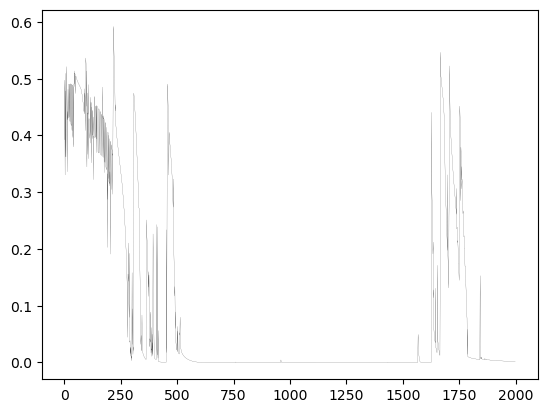

In [18]:
plt.plot(np.arange(0, N_epoch), costL, color='black', linewidth=0.1)

In [19]:
sample_num = 100
N_data = 4
from_zero = False

batch_form = jnp.zeros(batch_size)
phase_form = jnp.zeros([N_data, N])

test_ind = np.arange(0, N_epoch+1, 1)

phase0L = np.zeros([test_ind.shape[0], sample_num, N_data, N])
phase1L = np.zeros([test_ind.shape[0], sample_num, N_data, N])

k = 0

t0 = time.time()
for ind in test_ind:
    W = WL[ind,...]
    bias = biasL[ind,...]
    phase_0 = jax_init_phase(phase_form, input_index, training_data, batch_form, ind*ind, from_zero)
    run_func = lambda phase_0: v_run_network(phase_0, 100, W, bias, training_target, 0, input_index, output_index)
    phase_1 = jax.vmap(run_func)(phase_0)
    print(k)
    phase0L[k,...] = phase_0
    phase1L[k,...] = phase_1
    k = k+1
    
t1 = time.time()
print(t1-t0)

np.save("phase0L_N={0}".format(N), phase0L)
np.save("phase1L_N={0}".format(N), phase1L)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
N = 20

input_index = jnp.asarray([0,1])
output_index = jnp.asarray([N-1])
UA_model = SP_XY_Network(N, N_ev, dt, input_index, output_index)
UA_model.random_state_initiation()
UA_model.get_beta(beta)

all_cost_US3 = np.zeros([N_task, N_epoch])

W_0 = UA_model.weights_0
bias_0 = UA_model.bias_0

variable_index = UA_model.variable_index

training_paras = beta, study_rate
model_paras = N_ev, dt, input_index, variable_index, output_index

train_fun = lambda W_0, bias_0: single_train_US_model(W_0, bias_0, model_paras, training_paras, N_epoch, batch_size, study_rate, training_data, training_target)

t0 = time.time()
WL, biasL, costL = train_fun(W_0, bias_0)
t1 = time.time()

print('N=',N, t1-t0)
np.save("WL_N={0}".format(N), WL)
np.save("biasL_N={0}".format(N), biasL)
np.save("costL_N={0}".format(N), costL)

In [31]:
N = 20
N_epoch = 2000

WL = np.load("WL_N=20.npy")
biasL = np.load("biasL_N=20.npy")

sample_num = 100
N_data = 4
from_zero = False

batch_form = jnp.zeros(batch_size)
phase_form = jnp.zeros([N_data, N])

test_ind = np.arange(0, N_epoch+1, 1)

phase0L = np.zeros([test_ind.shape[0], sample_num, N_data, N])
phase1L = np.zeros([test_ind.shape[0], sample_num, N_data, N])

k = 0

t0 = time.time()
for ind in test_ind:
    W = WL[ind,...]
    bias = biasL[ind,...]
    phase_0 = jax_init_phase(phase_form, input_index, training_data, batch_form, ind*ind, from_zero)
    run_func = lambda phase_0: v_run_network(phase_0, 100, W, bias, training_target, 0, input_index, output_index)
    phase_1 = jax.vmap(run_func)(phase_0)
    #print(k)
    phase0L[k,...] = phase_0
    phase1L[k,...] = phase_1
    k = k+1
    
t1 = time.time()
print(t1-t0)

np.save("phase0L_N={0}".format(N), phase0L)
np.save("phase1L_N={0}".format(N), phase1L)

408.76836800575256


In [21]:
N = 30

input_index = jnp.asarray([0,1])
output_index = jnp.asarray([N-1])
UA_model = SP_XY_Network(N, N_ev, dt, input_index, output_index)
UA_model.random_state_initiation()
UA_model.get_beta(beta)

all_cost_US3 = np.zeros([N_task, N_epoch])

W_0 = UA_model.weights_0
bias_0 = UA_model.bias_0

variable_index = UA_model.variable_index

training_paras = beta, study_rate
model_paras = N_ev, dt, input_index, variable_index, output_index

train_fun = lambda W_0, bias_0: single_train_US_model(W_0, bias_0, model_paras, training_paras, N_epoch, batch_size, study_rate, training_data, training_target)

t0 = time.time()
WL, biasL, costL = train_fun(W_0, bias_0)
t1 = time.time()

print('N=',N, t1-t0)
np.save("WL_N={0}".format(N), WL)
np.save("biasL_N={0}".format(N), biasL)
np.save("costL_N={0}".format(N), costL)

In [30]:
sample_num = 100
N_data = 4
from_zero = False

batch_form = jnp.zeros(batch_size)
phase_form = jnp.zeros([N_data, N])

test_ind = np.arange(0, N_epoch+1, 1)

phase0L = np.zeros([test_ind.shape[0], sample_num, N_data, N])
phase1L = np.zeros([test_ind.shape[0], sample_num, N_data, N])

k = 0

t0 = time.time()
for ind in test_ind:
    W = WL[ind,...]
    bias = biasL[ind,...]
    phase_0 = jax_init_phase(phase_form, input_index, training_data, batch_form, ind*ind, from_zero)
    run_func = lambda phase_0: v_run_network(phase_0, 100, W, bias, training_target, 0, input_index, output_index)
    phase_1 = jax.vmap(run_func)(phase_0)
    #print(k)
    phase0L[k,...] = phase_0
    phase1L[k,...] = phase_1
    k = k+1
    
t1 = time.time()
print(t1-t0)

np.save("phase0L_N={0}".format(N), phase0L)
np.save("phase1L_N={0}".format(N), phase1L)

704.0186970233917


In [56]:
N = 30
N_epoch = 2000

In [57]:
phase1L = np.load("phase1L_N={0}.npy".format(N))

In [58]:
phase1L.shape

(2001, 100, 4, 30)

In [59]:
test_ind = np.arange(0, N_epoch+1, 1)

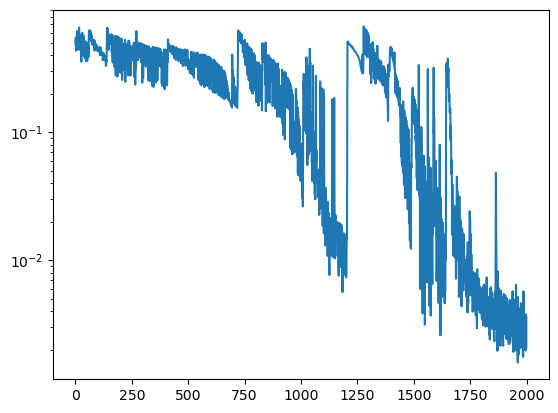

In [60]:
costL = np.load("costL_N={0}.npy".format(N))
plt.plot(np.arange(0,N_epoch), costL)
plt.yscale('log')

In [61]:
test_ind.shape

(2001,)

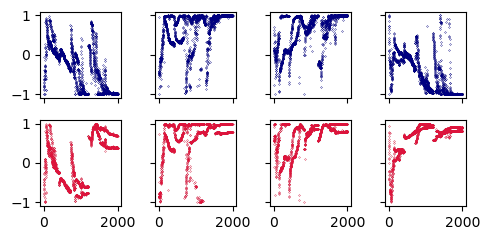

In [128]:
fig, ax = plt.subplots(2,4, figsize=(5,2.5), sharey=True, sharex=True)
for l in range(0,4):
    for k in range(0,5):
        ax[0, l].scatter(test_ind, jnp.sin(phase1L[:, k, l, N-1]), s=0.02, color='navy', marker='.')
        
for l in range(0,4):
    for k in range(0,5):
        ax[1, l].scatter(test_ind, jnp.sin(phase1L[:, k, l, N-7]), s=0.02, color='crimson', marker='.')
        
fig.tight_layout()

fig.savefig('new_fig2-d.pdf', bbox_inches='tight', dpi='figure')

In [ ]:
# fig, ax = plt.subplots(4,1)
for l in range(0,4):
    for k in range(0,100):
        ax[l].scatter(test_ind, jnp.sin(phase1L[:, k, l, N-5]), s=0.1, color='black')

In [124]:
A = np.load("N=10_all_cost.npy")

In [125]:
A.shape

(7, 100, 1000)

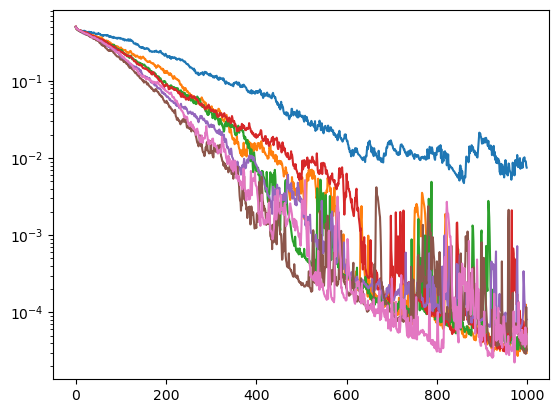

In [127]:
for k in range(0,7):
    plt.plot(np.arange(0,1000), np.mean(A, axis=1)[k,:])
    
plt.yscale('log')